# Schweppe et al. - Real Time Search TMT

## Testing cell lines: RTS before IRS

### Phil Wilmarth, OHSU

### May 27, 2020

## Re-analysis of PXD017823 (human cell lines) 

The PRIDE data was just the human cell line data presented in Figure 4 from the [JPR publication](https://pubs.acs.org/doi/10.1021/acs.jproteome.9b00860). There are HTC116 cells (first 3 channels), MCF7 cells (the next 3 channels), and HEK293 cells (the last 4 channels) labeled with 10-plex TMT. A 180-minute RP LC method for a 12-fraction separation (high pH RP) using the regular SPS MS3 acquisition was compared to running the 12-fractions with a 90-minute SPS MS3 method using real time search (RTS) and protein close-out. Protein close-out is not described in the methods or in citation 4 (only described in a figure caption) but is (maybe) restricting MS3 scans after 4 successful scans have been acquired for a particular protein.

The data from PRIDE was downloaded and processed with my [PAW pipeline](https://github.com/pwilmart/PAW_pipeline):

- Use [MSConvert](http://proteowizard.sourceforge.net/) to make GZipped text files with MS2 and MS3 scans
- Run wide tolerance [Comet](http://comet-ms.sourceforge.net/) searches (simple configuration)
- Compile top-hit PSM summaries (discriminant scores) with reporter ion peak heights
- Accurate mass conditioned target/decoy score histograms to control 1% PSM FDR
- Basic and extended parsimonious protein inference
- Summed reporter ion totals computed for peptides and proteins
- [Internal Reference Scaling (IRS)](https://www.mcponline.org/content/16/5/873) normalization

There are multiple comparisons that can be made. We compared the two acquisition methods that were done in two separate TMT experiments with internal reference scaling (IRS) in our first notebook. We will continue with some statistical testing of the differences between the cell lines. 

While IRS did seem to work, the real time search data with protein close-out was quite different. We will start with the SLNormalized data from each experiment for the initial testing work. We will take the data from the IRS normalization script table. That takes care of finding the intersection of the protein IDs. We will have the same starting set of proteins from each experiment for testing. We will start with the RTS experiment before IRS first and do our usual edgeR testing with notebooks.


### References

> Devin K. Schweppe, Jimmy K. Eng, Qing Yu, Derek Bailey, Ramin Rad, Jose Navarrete-Perea, Edward L. Huttlin, Brian K. Erickson, Joao A. Paulo, and Steven P. Gygi, 2020. Full-Featured, Real-Time Database Searching Platform Enables Fast and Accurate Multiplexed Quantitative Proteomics. Journal of proteome research, 19(3), pp.2026−2034.

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> www.jupyter.org

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)
library(janitor)

# set global plot size (default is 7x7 inch)
options(repr.plot.width=9, repr.plot.height=9)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

## Load the IRS-normalized TMT intensity data

The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is relatively straightforward. Note than this experimental design has only a single "mock" reference channel per plex instead of two.

We need to drop contaminant and decoy proteins, and proteins with missing sets of reporter ions. We extract the accessions column and the data columns of interest.

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", guess_max = 8245)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))

# get the pooled channels
data_pools <- data_all %>% select(., contains("Pool")) %>%
  select(., contains("Norm_"))

# clean up column names 
data_all <- data_all %>% rename_all(funs(str_replace(., "Norm_", "_"))) %>% 
  rename_all(funs(str_replace(., "RTS_1", "RTS"))) %>% 
  rename_all(funs(str_replace(., "Reg_2", "Reg"))) 

# get the data before and after IRS
data_sl <- select(data_all, contains("SL_"), -contains("Pool"))
data_irs <- select(data_all, contains("IRS_"), -contains("Pool"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”


[1] 7469

## Get the experiment to compare cell lines within

We will start with the real time search (RTS) experiment before IRS.

In [4]:
# define the acquisition mode of interest
acq_mode  <- "RTS"

# define data (SL or IRS) and define the cell line indices
df <- select(data_sl, contains(acq_mode))
HCT <- 1:3
MCF <- 4:6
HEK <- 7:10

# set some colors by cell line
colors = c(rep('red', length(HCT)), rep('blue', length(MCF)), rep('green', length(HEK)))

## Run TMM normalization and check final clustering 

We will the data into `edgeR` data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 SL_HCT116_1_RTS -> 1.000254
 SL_HCT116_2_RTS -> 1.000122
 SL_HCT116_3_RTS -> 1.000384
 SL_MCF_1_RTS -> 0.999608
 SL_MCF_2_RTS -> 0.999697
 SL_MCF_3_RTS -> 0.999652
 SL_HEK293_1_RTS -> 0.999982
 SL_HEK293_2_RTS -> 0.999680
 SL_HEK293_3_RTS -> 1.000249
 SL_HEK293_4_RTS -> 1.000372

Trimmed mean of M-values (TMM) factors:
 SL_HCT116_1_RTS -> 1.030440
 SL_HCT116_2_RTS -> 1.027667
 SL_HCT116_3_RTS -> 1.018184
 SL_MCF_1_RTS -> 1.066603
 SL_MCF_2_RTS -> 1.042902
 SL_MCF_3_RTS -> 1.055913
 SL_HEK293_1_RTS -> 0.946358
 SL_HEK293_2_RTS -> 0.952034
 SL_HEK293_3_RTS -> 0.939966
 SL_HEK293_4_RTS -> 0.932404

Combined (lib size and TMM) normalization factors:
 SL_HCT116_1_RTS -> 1.030702
 SL_HCT116_2_RTS -> 1.027792
 SL_HCT116_3_RTS -> 1.018575
 SL_MCF_1_RTS -> 1.066186
 SL_MCF_2_RTS -> 1.042586
 SL_MCF_3_RTS -> 1.055546
 SL_HEK293_1_RTS -> 0.946341
 SL_HEK293_2_RTS -> 0.951730
 SL_HEK293_3_RTS -> 0.940200
 SL_HEK293_4_RTS -> 0.932751


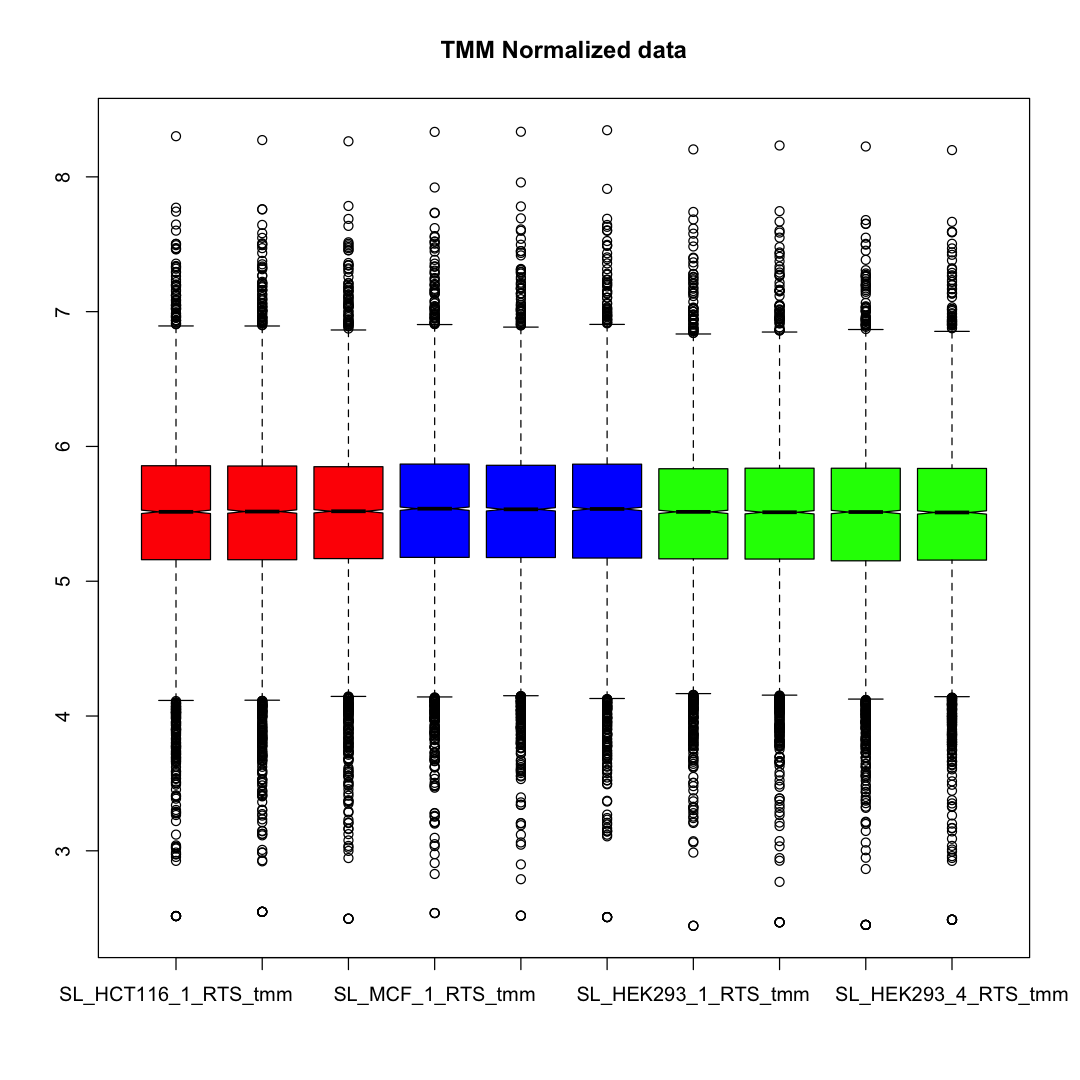

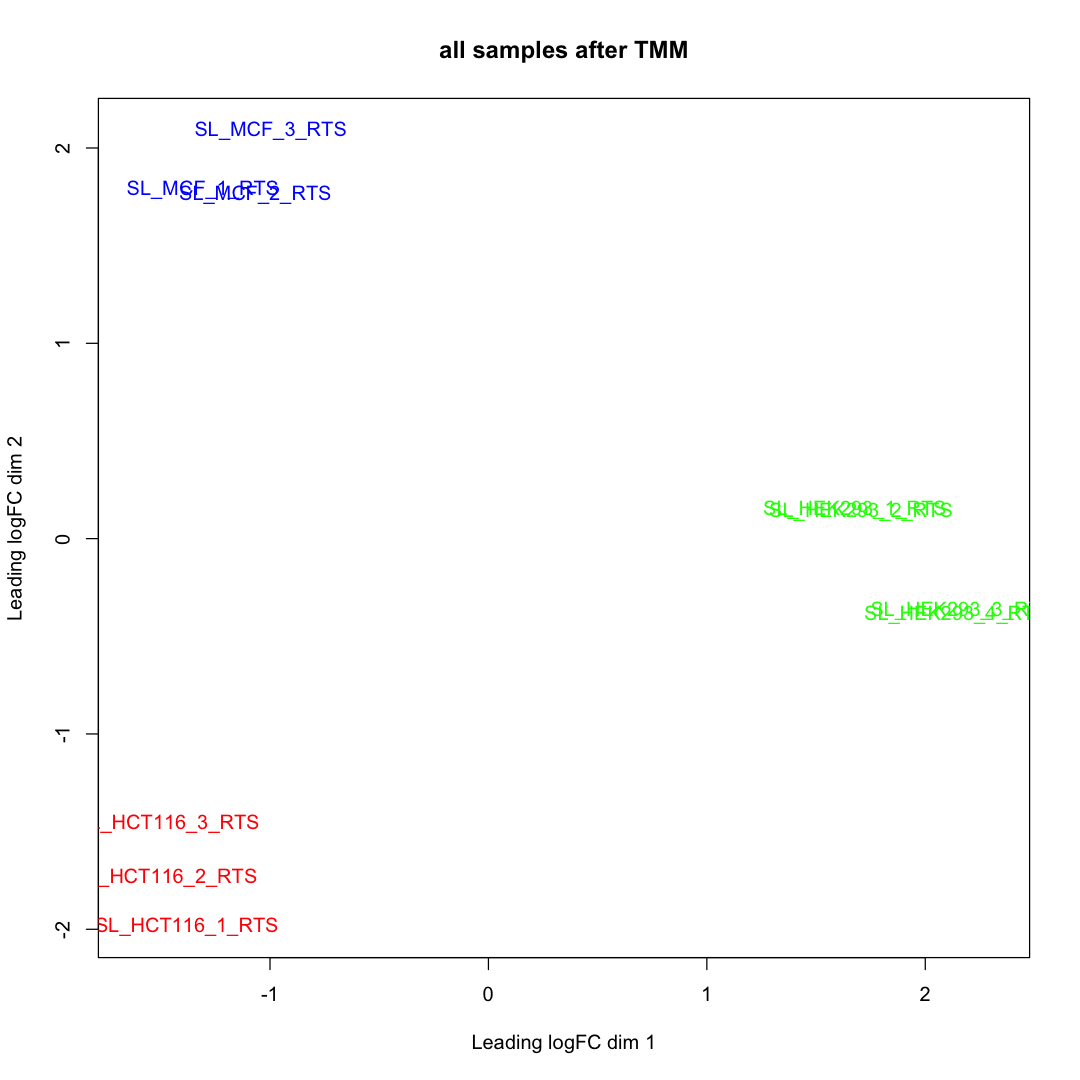

In [5]:
# get the biological sample data into a DGEList object
groups = c(rep("HCT", length(HCT)), rep("MCF", length(MCF)), 
          rep("HEK", length(HEK)))
y <- DGEList(counts = df, group = groups, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the actual normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors)

# check the clustering after TMM
plotMDS(y, col = colors, main = "all samples after TMM")

### TMM factors are close to 1.0

The IRS method already takes care of the library size type of normalizations. All of the library adjustment facters were very small. We could still have compositional differences between sample groups that the TMM factors would correct for. We do see some consistent differences by cell line for the TMM factors.

The box plots are very similar. TMM usually gets the medians (box centers) aligned pretty well. 

# EdgeR statistical testing starts here

## Compute the shared variance trend

One of the most powerful features of `edgeR` (and `limma`) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 10 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We loaded the IRS data into `DGEList` object `y` a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in `y`.

Design matrix not provided. Switch to the classic mode.


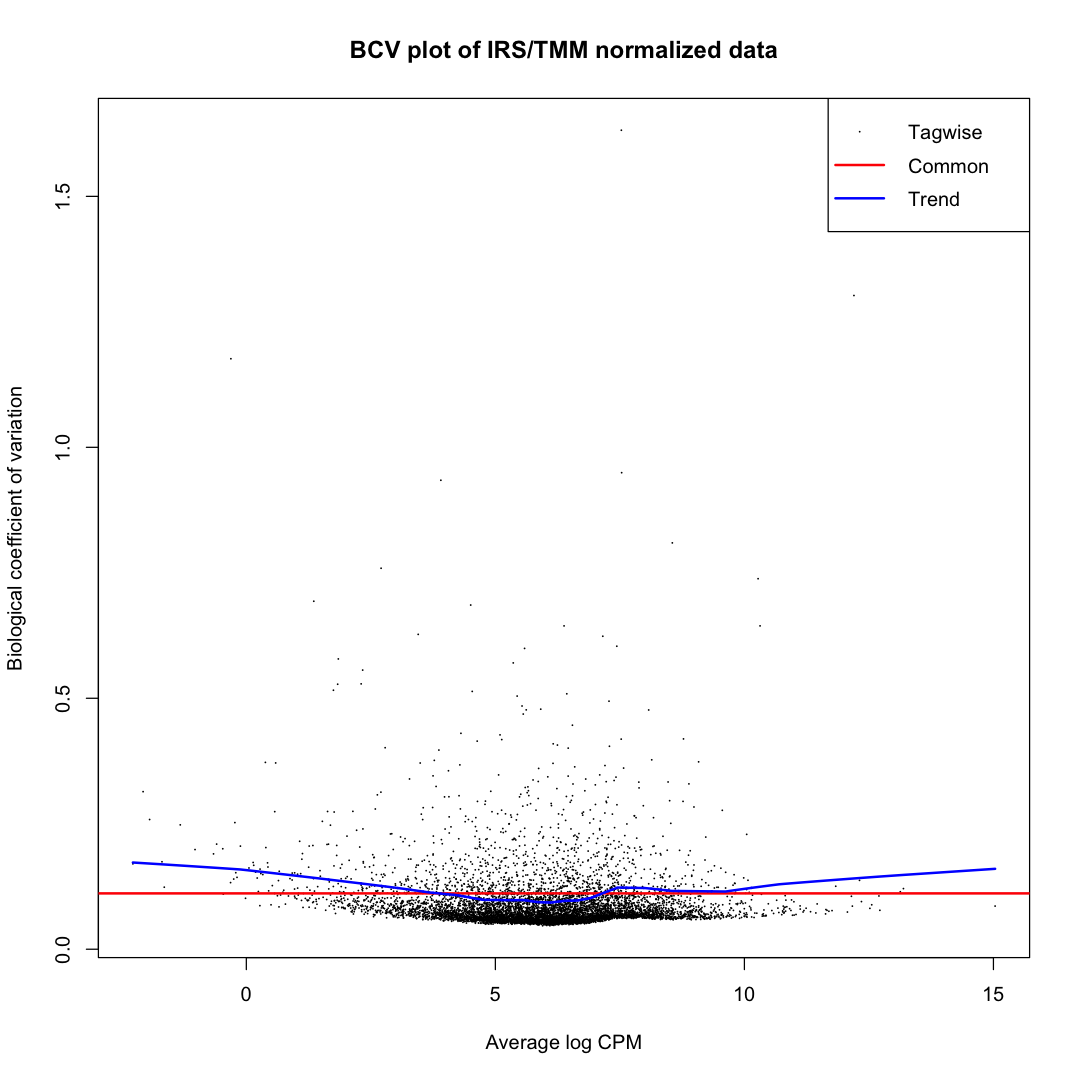

In [6]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## (1) HCT116 versus MCF7

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `decideTestsDGE` call will tell us how many up and down regulated candidates we have at an FDR of 0.05. The `topTags` call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and then check the p-value distribution.

       MCF-HCT
Down      2857
NotSig    1816
Up        2796

genes                 logFC    logCPM   PValue        FDR          
6861 sp|O60315|ZEB2_HUMAN  4.088692 5.056569  0.000000e+00  0.000000e+00
5756 sp|Q9HAV0|GBB4_HUMAN  3.480935 5.293063  0.000000e+00  0.000000e+00
5207 sp|Q9UBW7|ZMYM2_HUMAN 3.473078 4.163817  0.000000e+00  0.000000e+00
6431 sp|O75051|PLXA2_HUMAN 3.696770 5.224785 7.180464e-282 1.340772e-278
4498 sp|Q96DA2|RB39B_HUMAN 3.629498 6.709690 8.952446e-275 1.337316e-271
3739 sp|Q9NX05|F120C_HUMAN 2.495157 6.415236 2.891008e-267 3.598823e-264
3173 sp|Q3V6T2|GRDN_HUMAN  2.376990 6.032681 5.375189e-265 5.735327e-262
5112 sp|Q9UN81|LORF1_HUMAN 2.853769 5.806009 6.273997e-263 5.857560e-260
4215 sp|O43505|B4GA1_HUMAN 2.348031 5.748291 6.280506e-260 5.212122e-257
361  sp|P46821|MAP1B_HUMAN 3.636825 7.170620 2.320154e-257 1.732923e-254

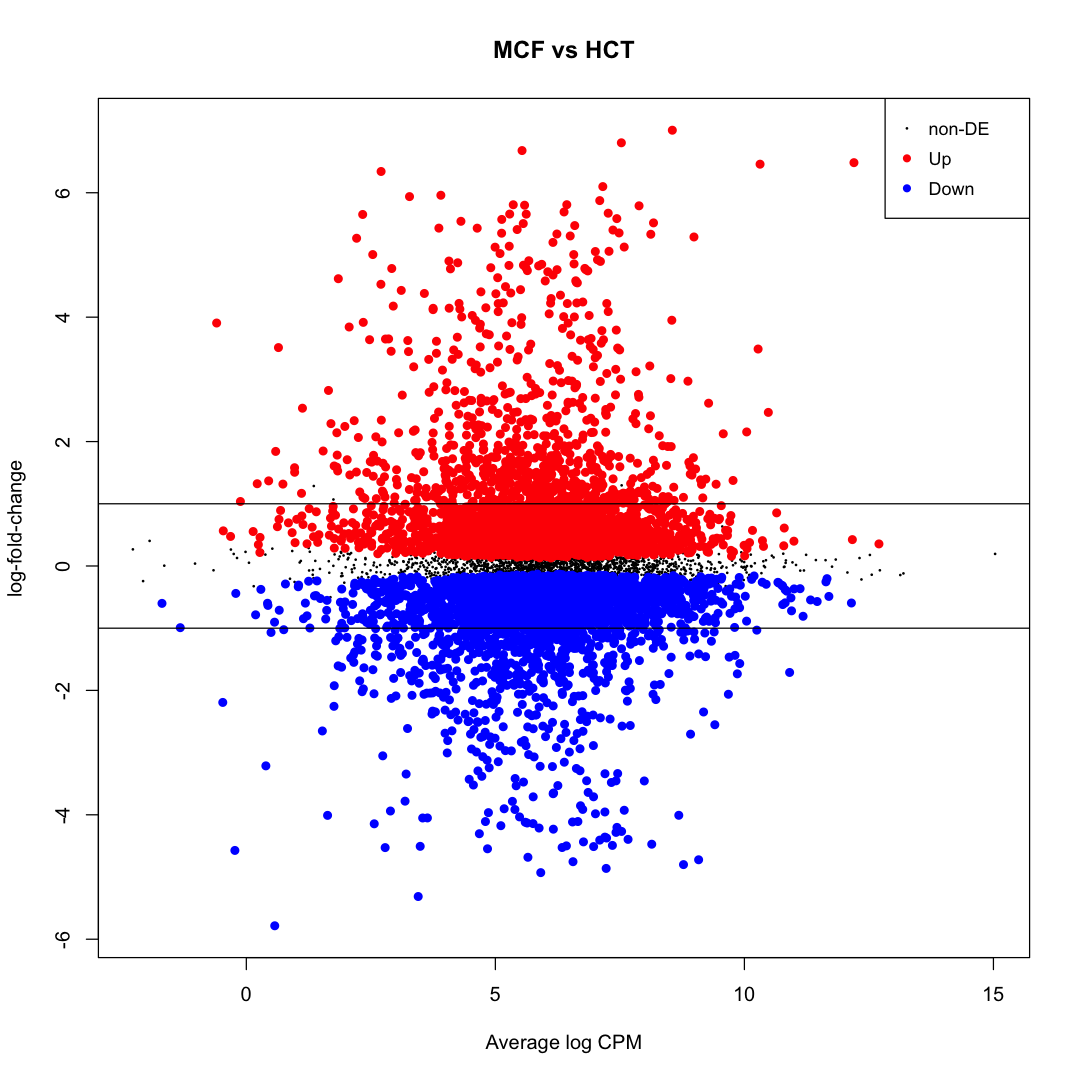

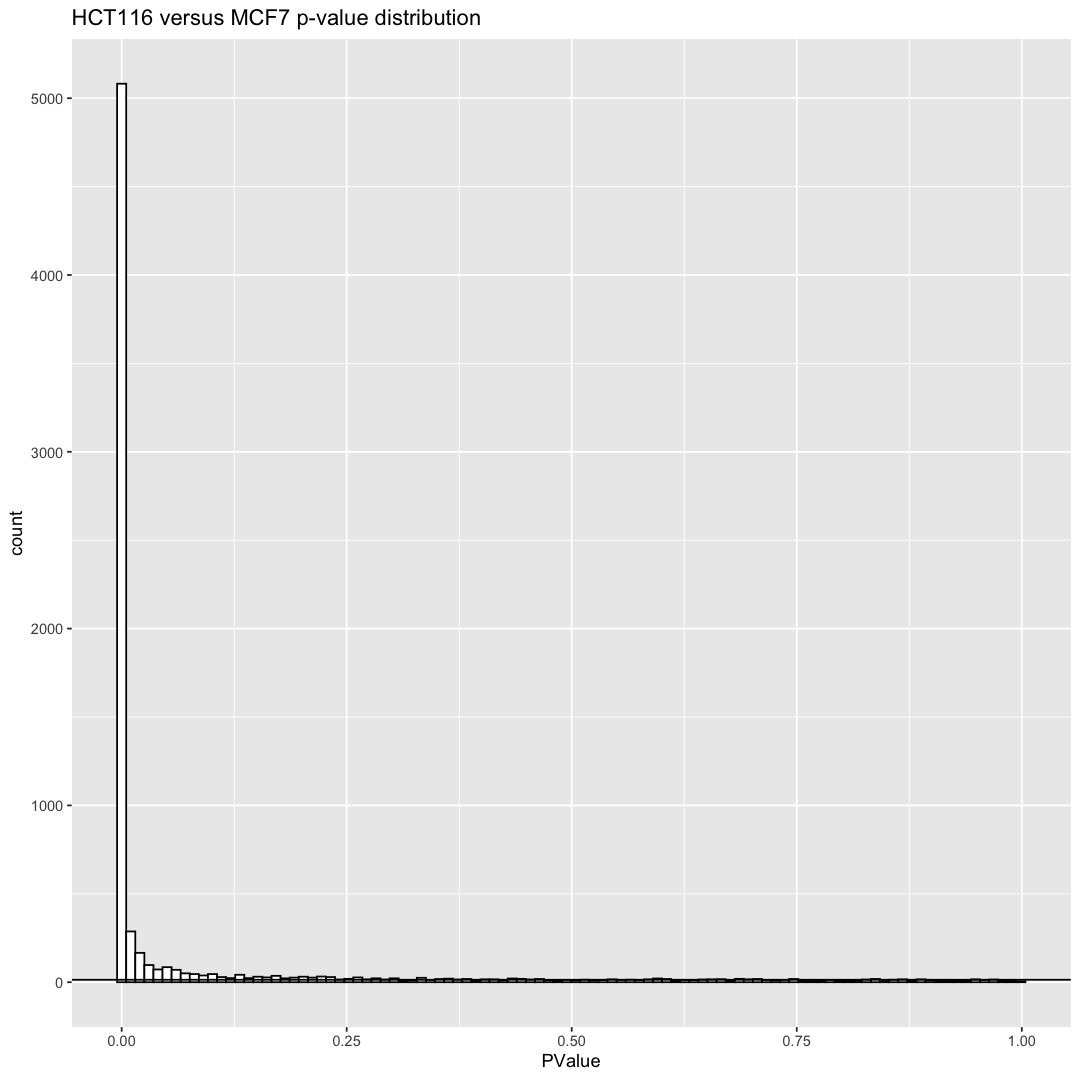

In [7]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("HCT", "MCF"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.05))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.05)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("HCT116 versus MCF7 p-value distribution")

### We have many candidates!

We have about 75% of the proteins being differentially expressed. There are likely real differences in these cell lines. We also have very low CVs for most proteins (median CVs are around 5%), so pretty small expression differences are going to be statistically significant. EdgeR, with the trended dispersion, tends to be more conservative, i.e. requires a larger difference in means, than a basic t-test. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we do not have many candidates, we will still make the MA plots, scatter plots, and volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [8]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, HCT, "HCT", MCF, "MCF")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_HCT_MCF")

# accumulate the testing results
all_results <- results_temp

### Count candidates and look at fold-change distributions

candidate n   
1 high      5160
2 med        493
3 low        276
4 no        1540

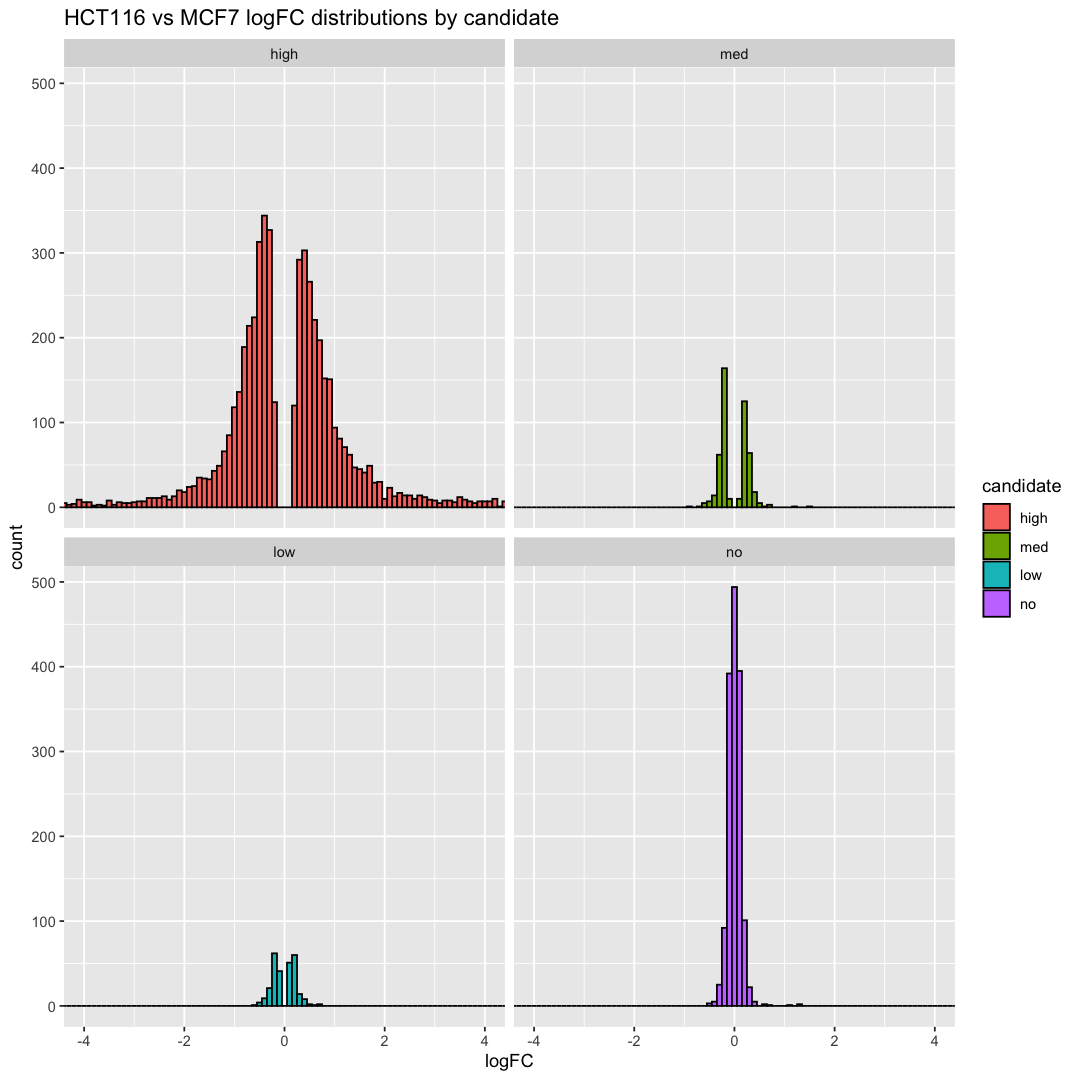

In [9]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("HCT116 vs MCF7 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

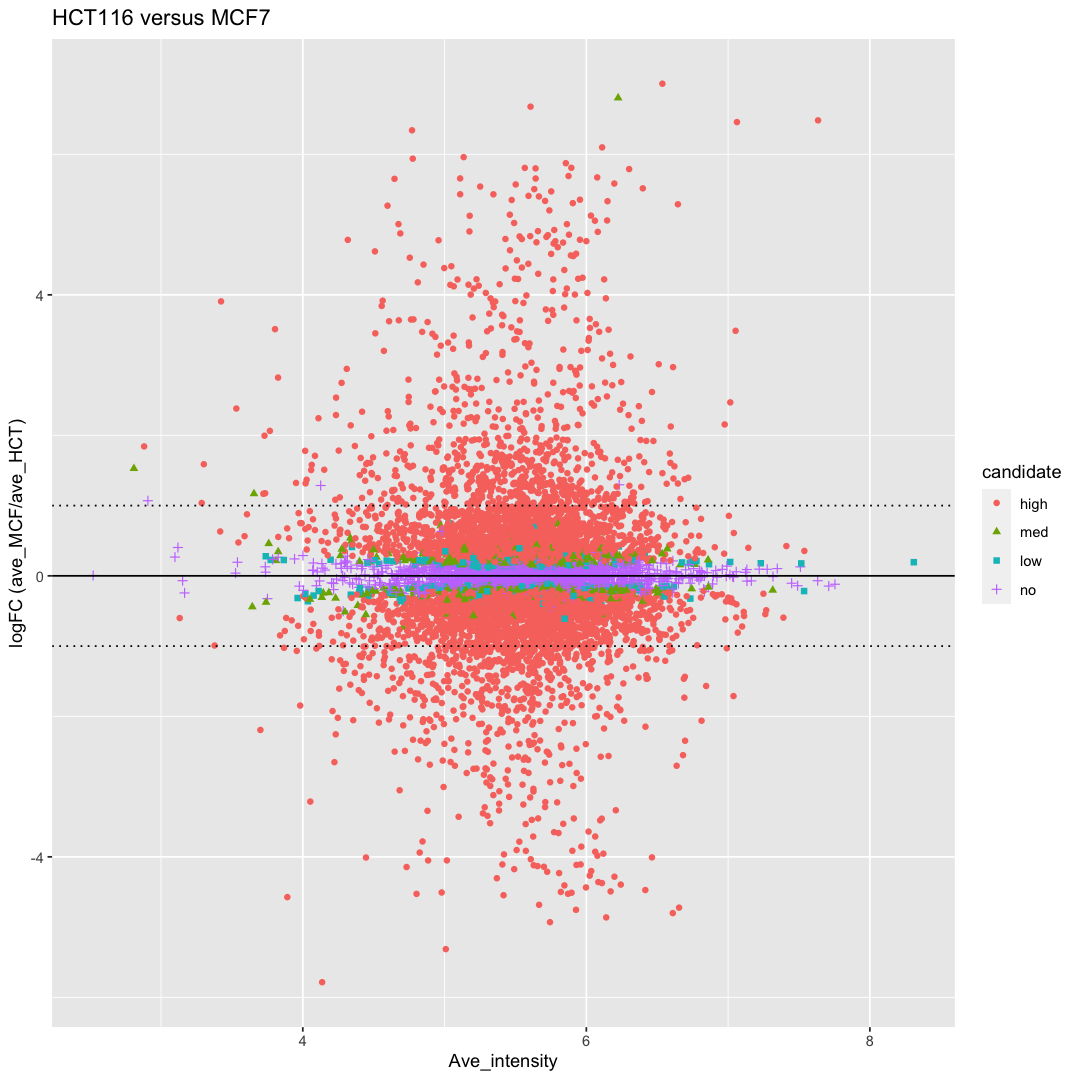

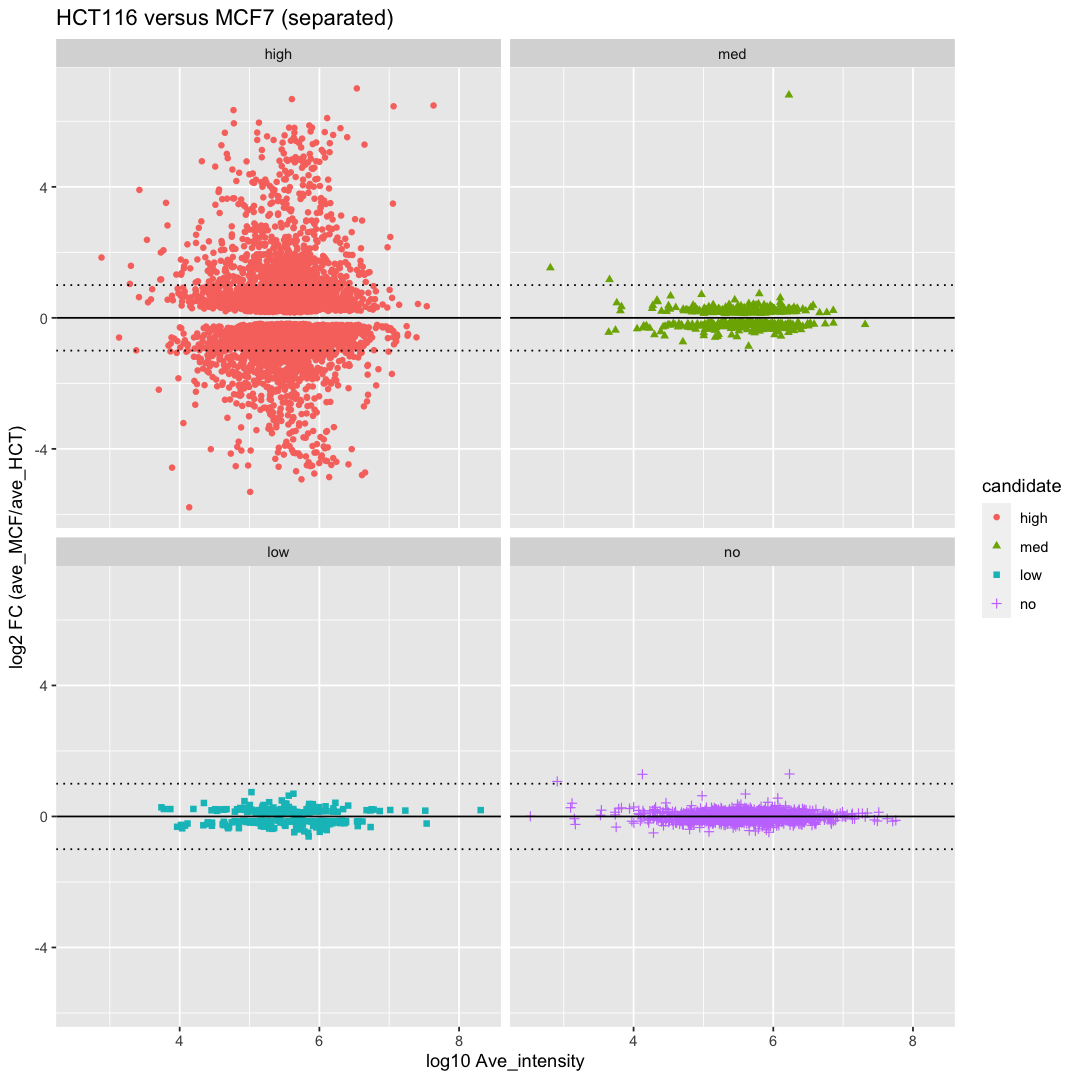

In [10]:
# make MA plots
MA_plots(results, "ave_HCT", "ave_MCF", "HCT116 versus MCF7")

### Scatter plots

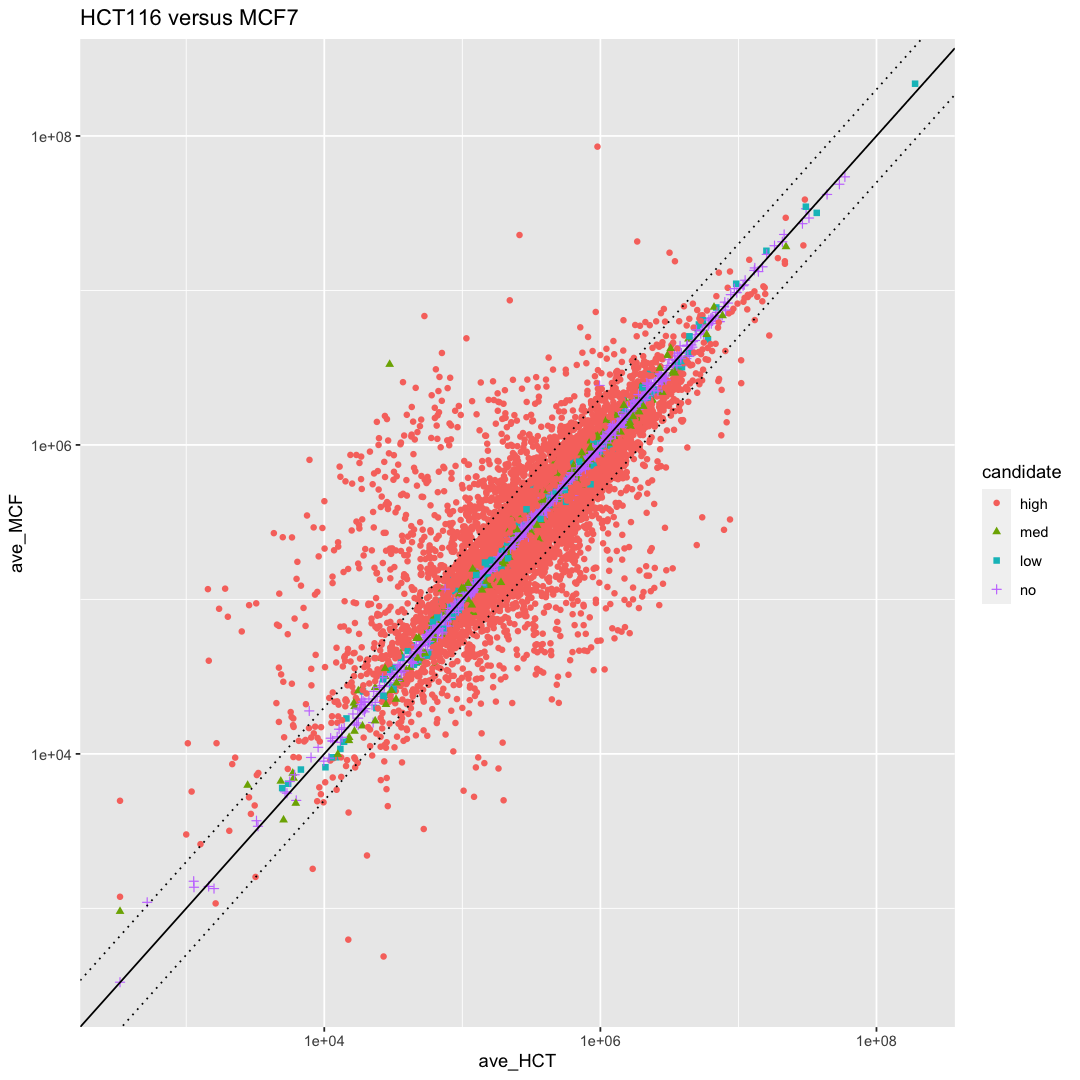

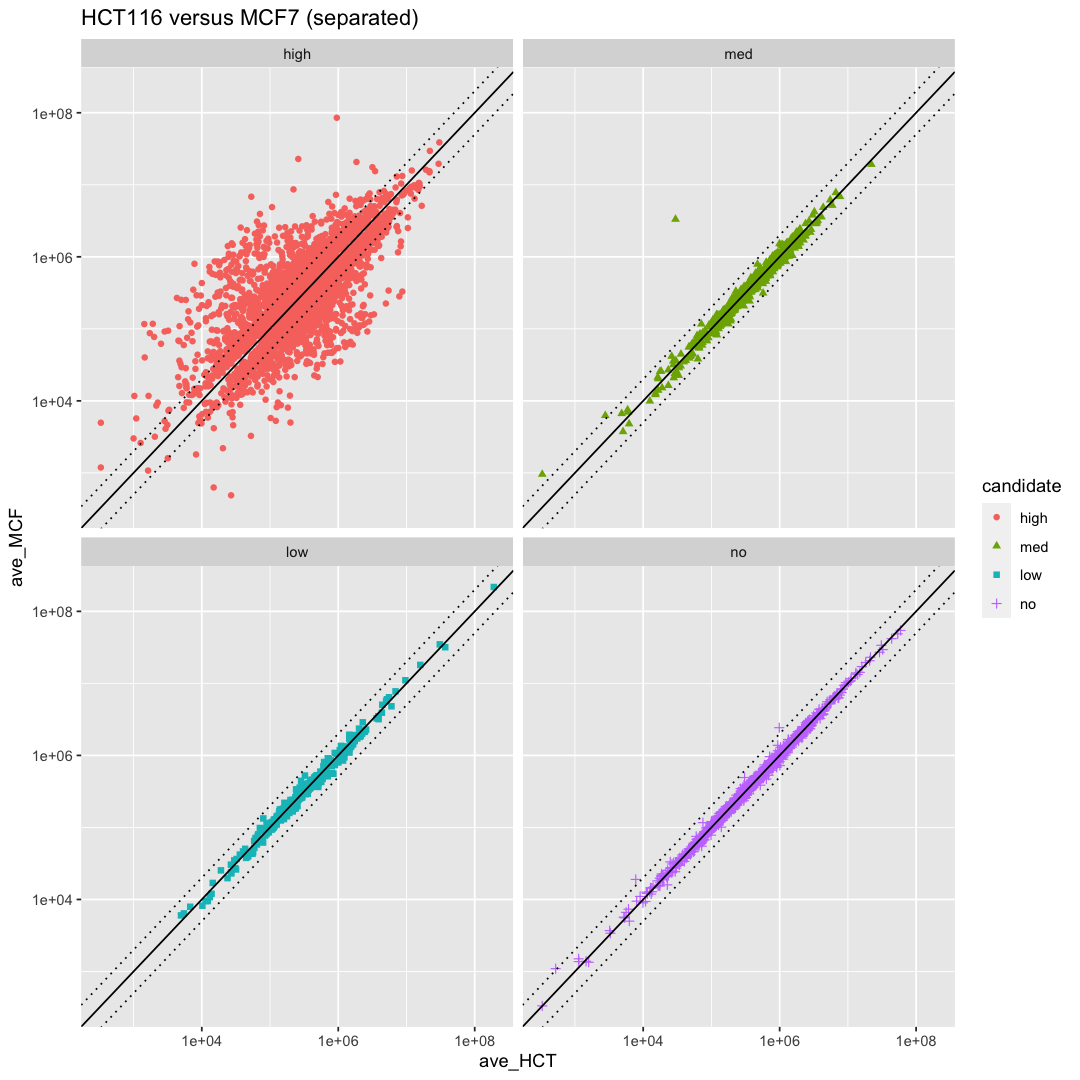

In [11]:
# make scatter plots
scatter_plots(results, "ave_HCT", "ave_MCF", "HCT116 versus MCF7")

### Volcano plot

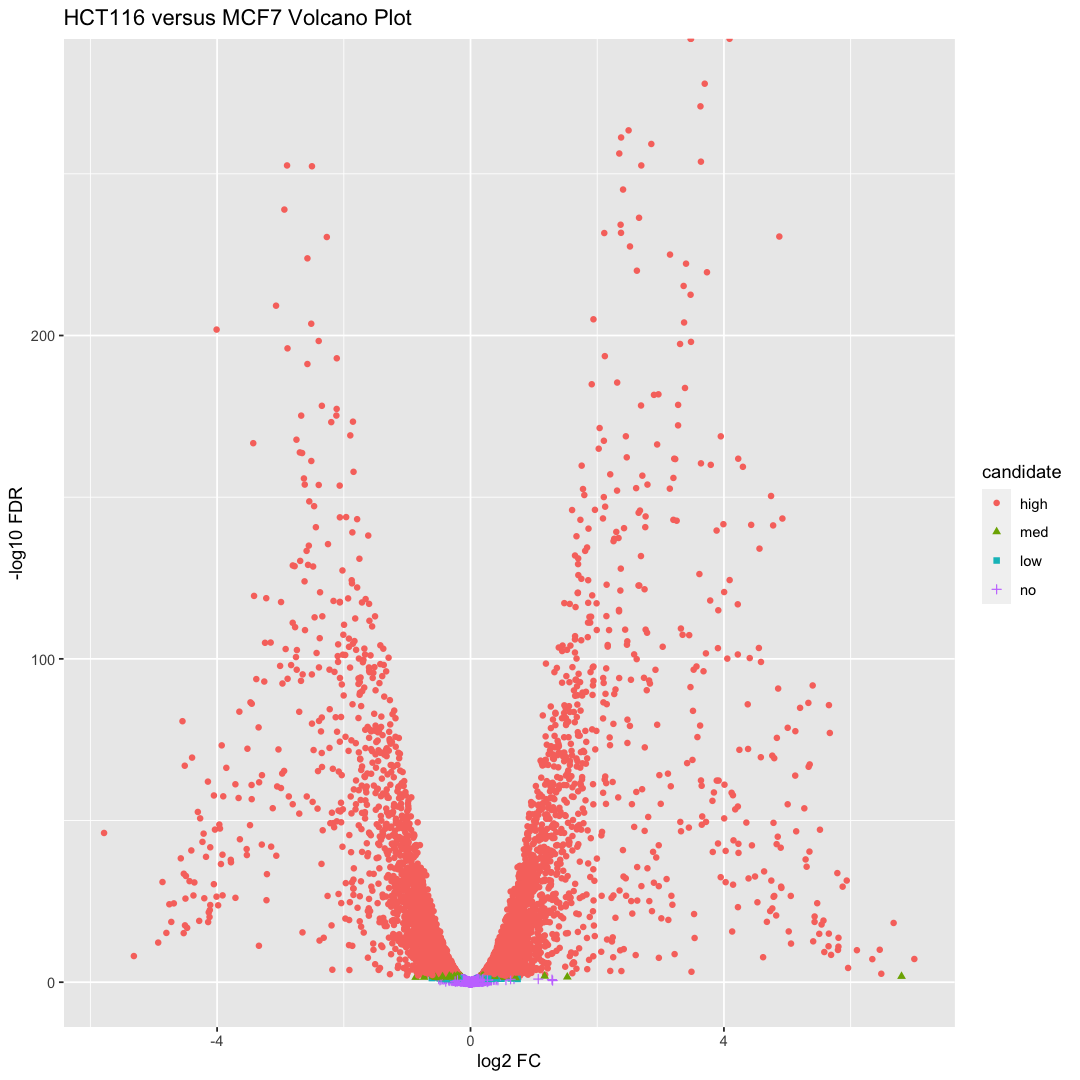

In [12]:
# make a volcano plot
volcano_plot(results, "ave_HCT", "ave_MCF", "HCT116 versus MCF7")

In [13]:
# count proteins with FC more than 2-fold
nrow(filter(results, abs(FC) > 2 & candidate != "no"))

[1] 1475

### Candidates look strong

There are many candidates with more than 2-fold expression changes. We do have many candidates with smaller fold-changes due to the low CVs.

### Check some individual protein expression

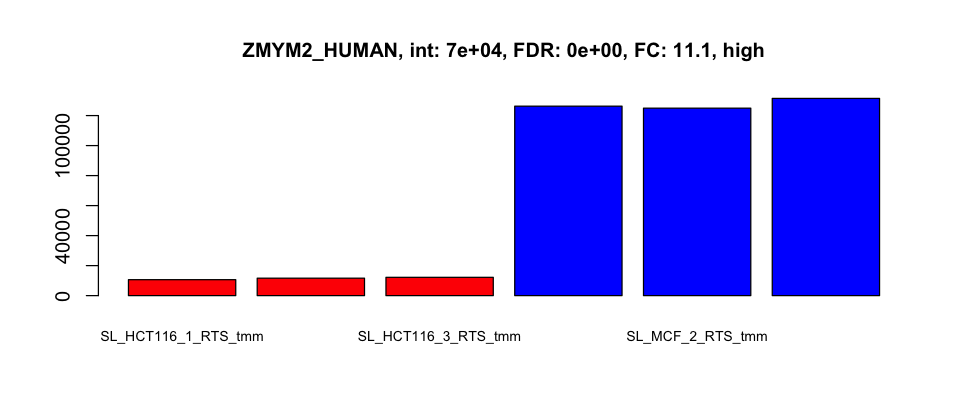

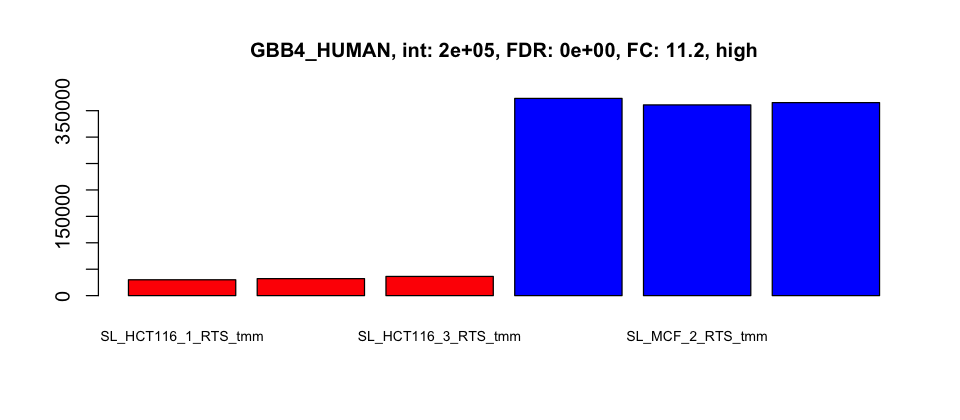

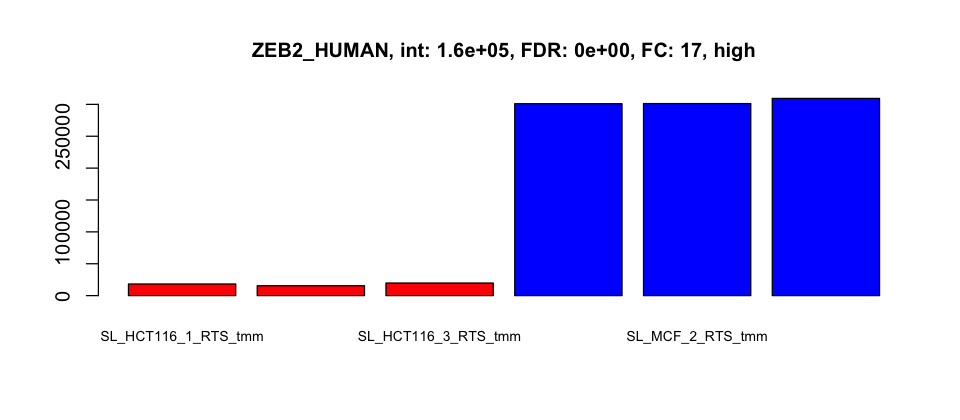

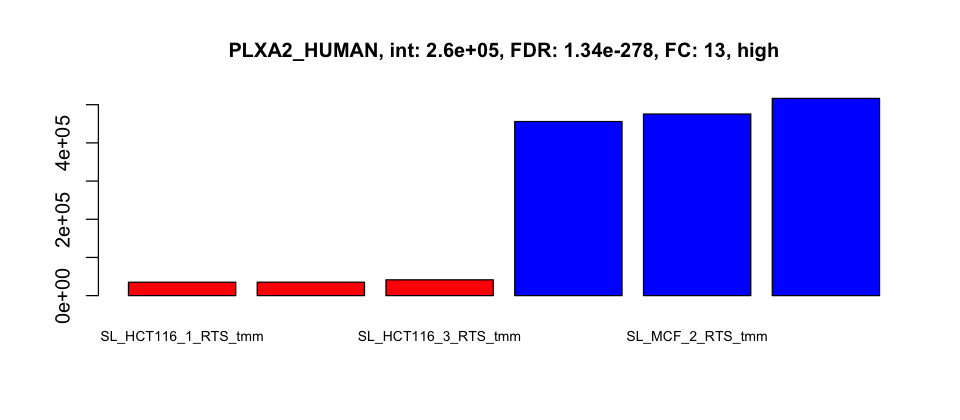

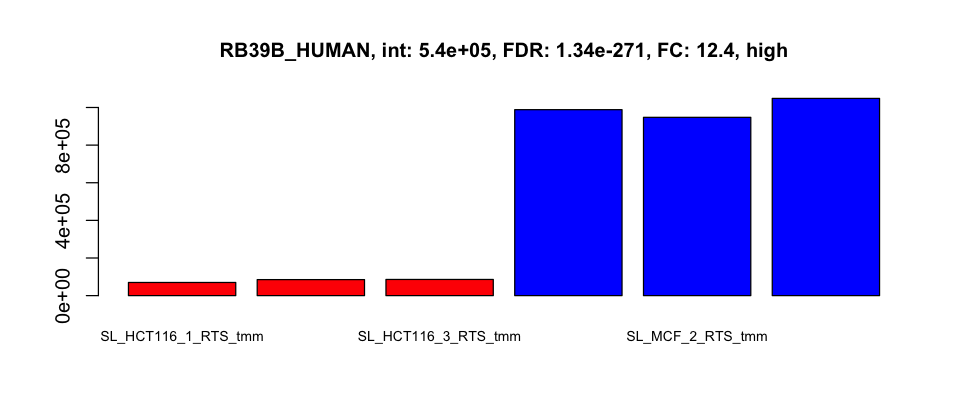

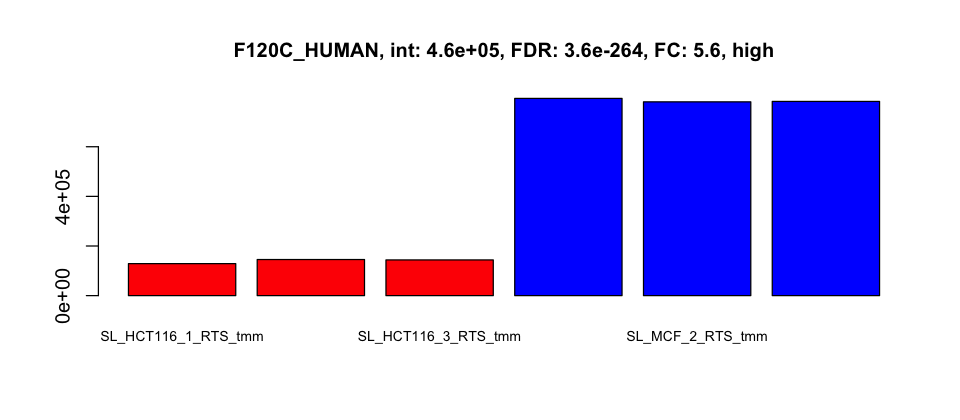

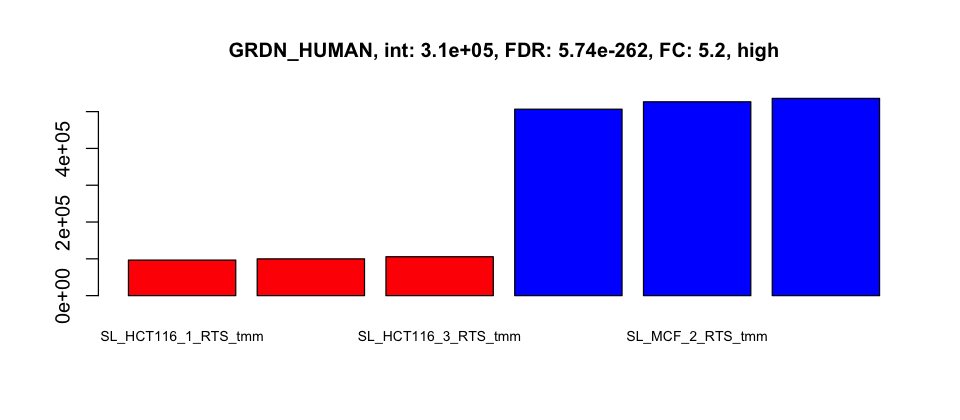

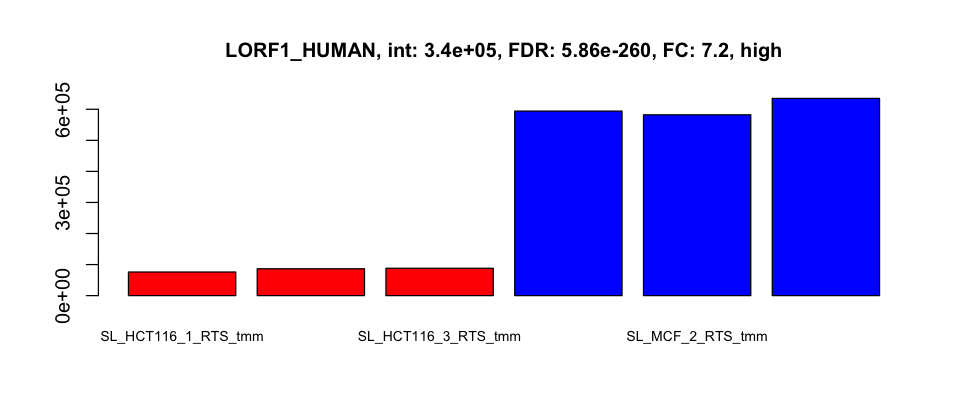

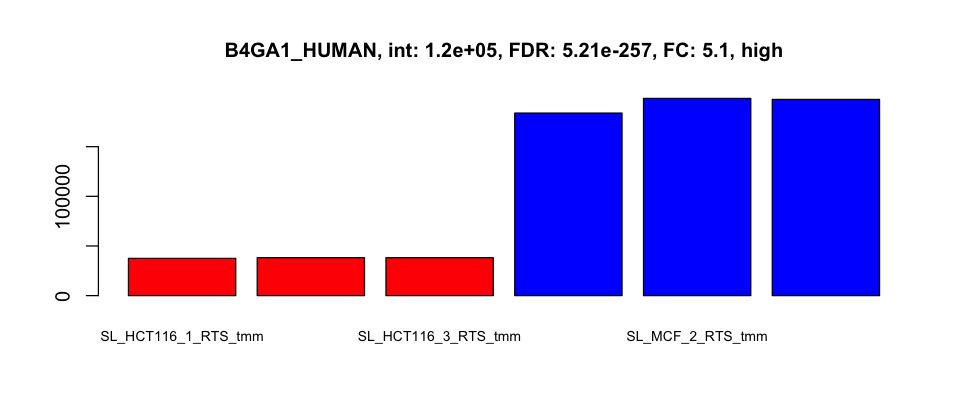

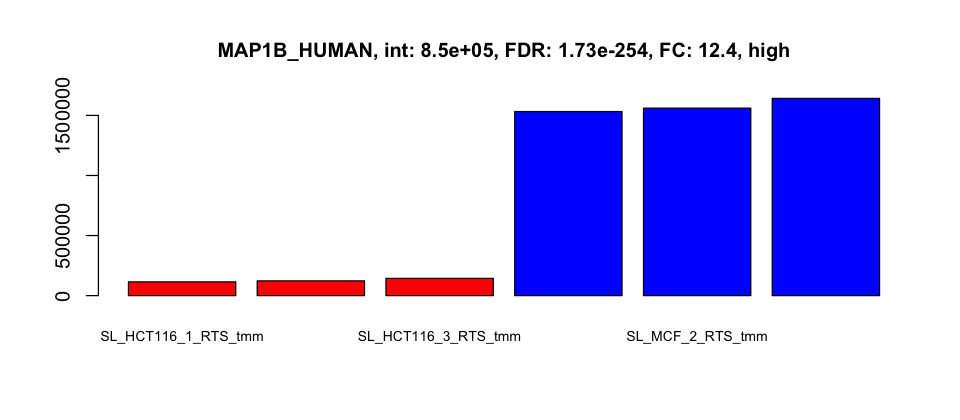

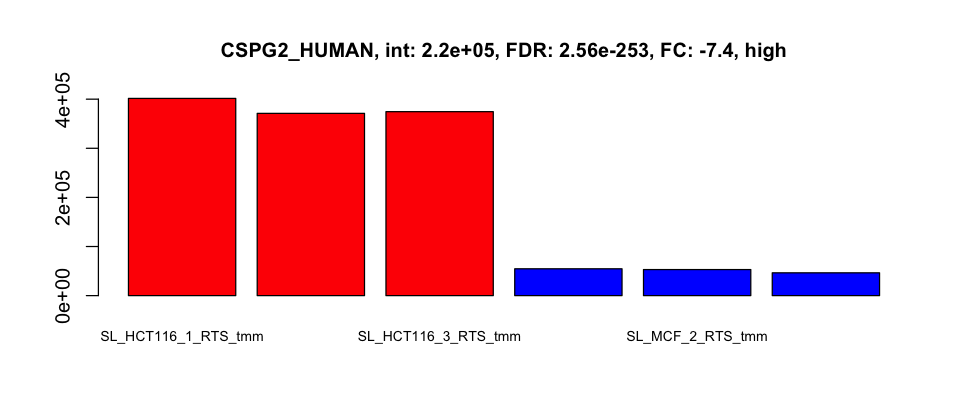

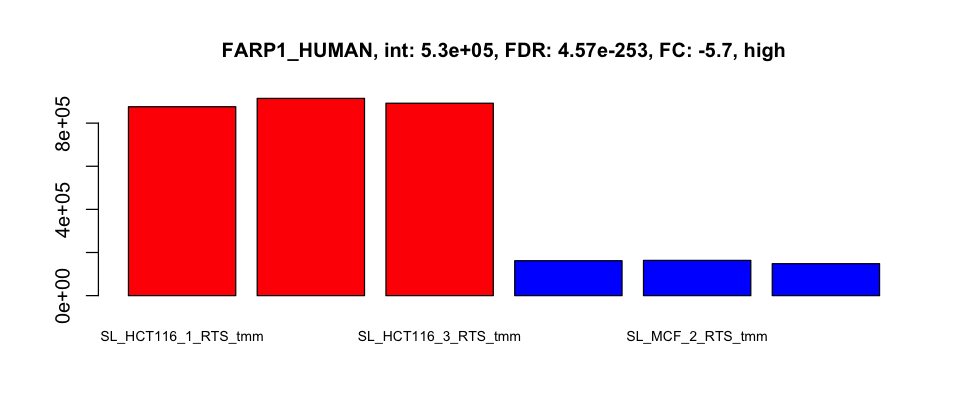

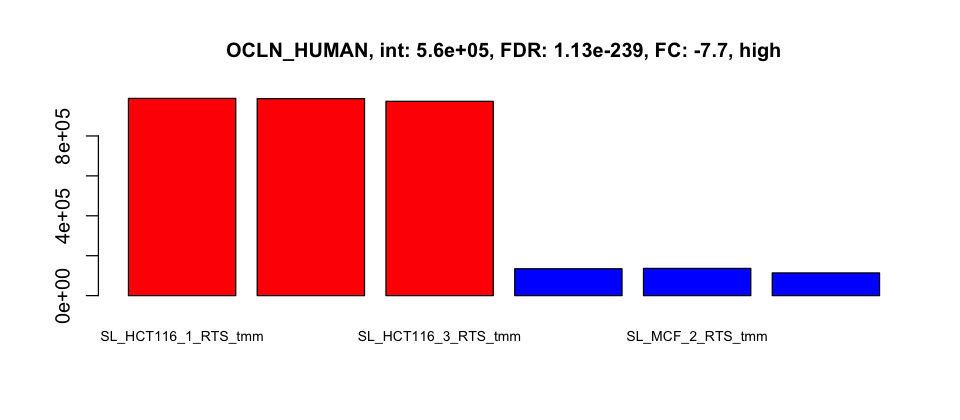

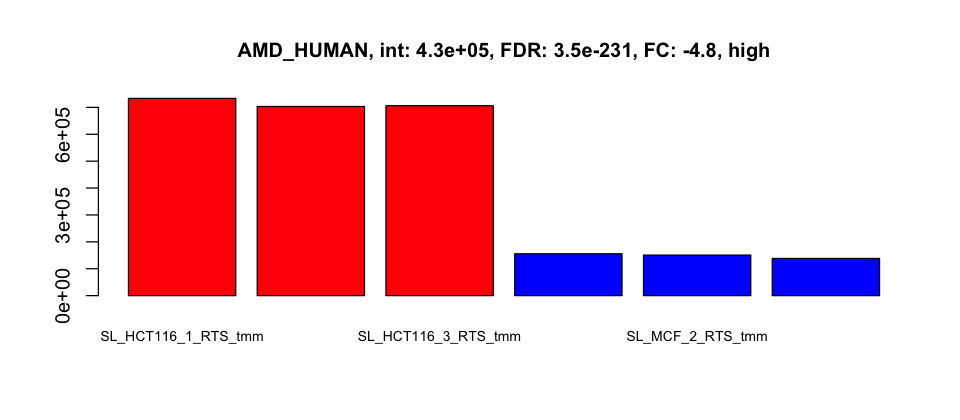

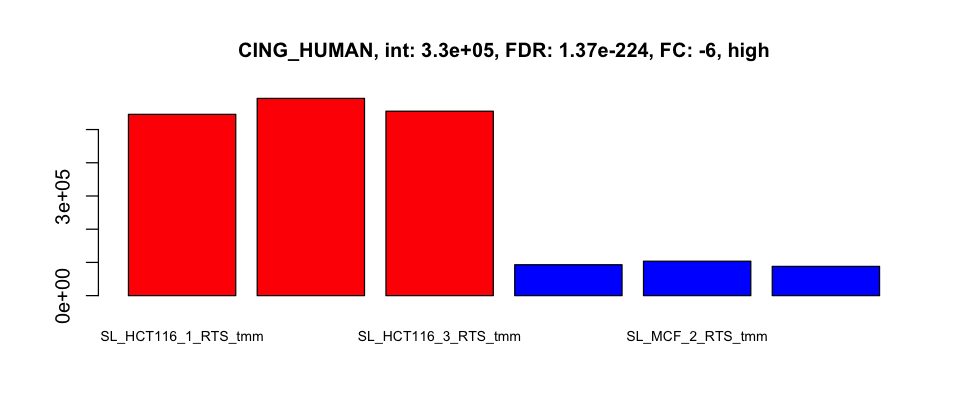

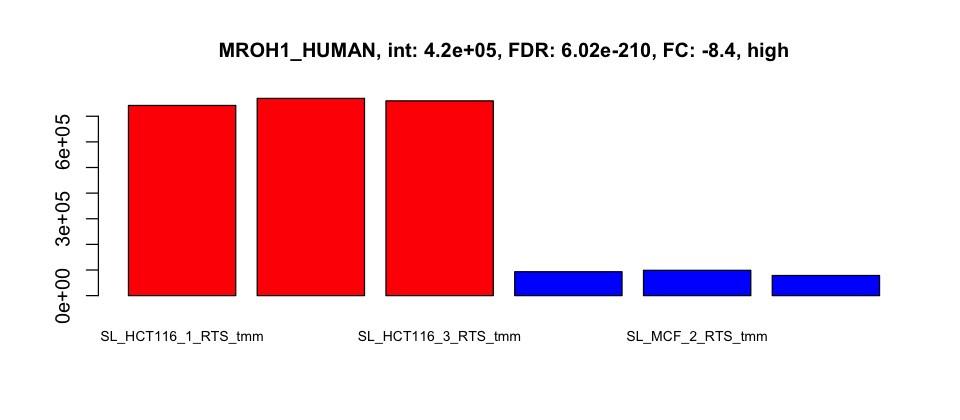

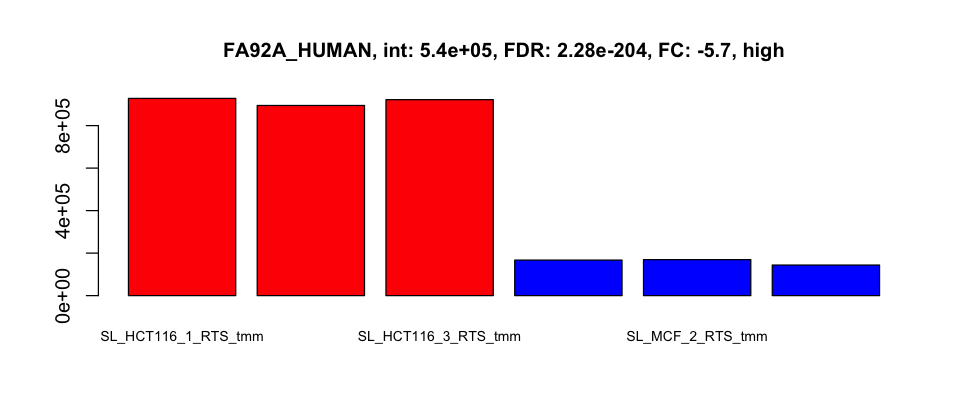

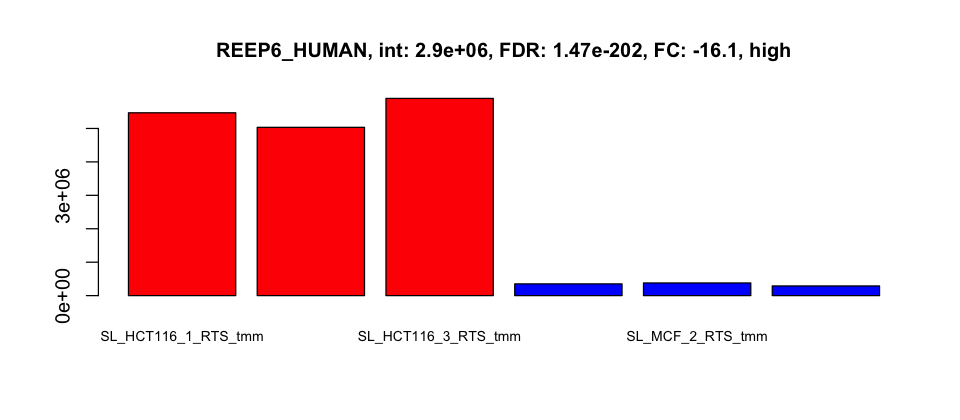

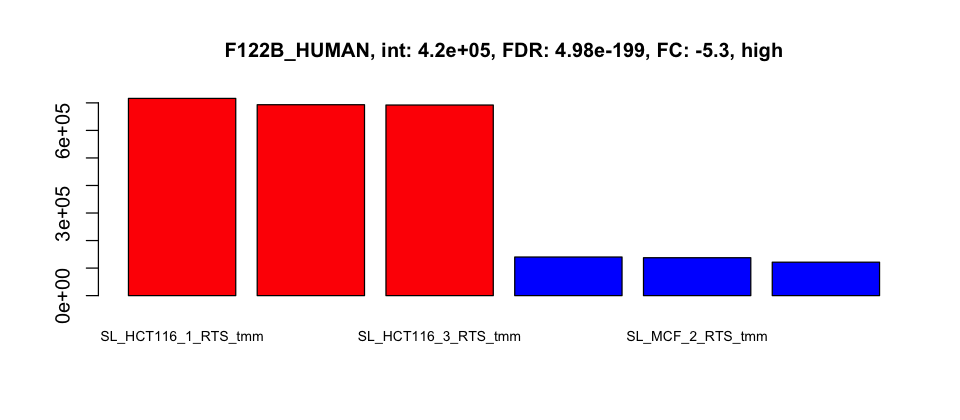

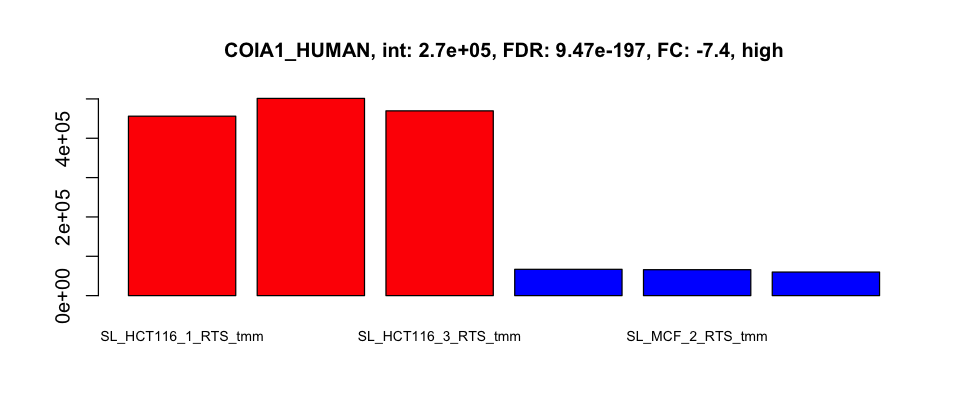

In [14]:
# look at the top candidates
set_plot_dimensions(8, 3.5)
plot_top_tags(results, 3, 3, 10)
set_plot_dimensions(9, 9)

### The top candidates are convincing

We have ridiculously small testing p-values, large fold changes, and minimal variation between cell line biological replicates.

## (2) HCT116 versus HEK293

We will do the same testing to compare HCT116 cells versus HEK293 cells.

       HEK-HCT
Down      2944
NotSig    1707
Up        2818

genes                 logFC     logCPM   PValue FDR
6931 sp|O95490|AGRL2_HUMAN  5.398592 4.026982 0      0  
5803 sp|Q8ND83|SLAI1_HUMAN  5.061401 5.299624 0      0  
5459 sp|Q56VL3|OCAD2_HUMAN -4.845393 5.679299 0      0  
6240 sp|Q99715|COCA1_HUMAN -4.788465 4.816953 0      0  
1982 sp|Q9H6S3|ES8L2_HUMAN -4.501907 7.014051 0      0  
6298 sp|Q9BYP7|WNK3_HUMAN   4.434997 4.987713 0      0  
4831 sp|Q96T17|MA7D2_HUMAN  4.405354 4.660025 0      0  
3794 sp|P29350|PTN6_HUMAN  -4.314386 5.958848 0      0  
4011 sp|Q9HBK9|AS3MT_HUMAN  4.279071 6.834875 0      0  
3912 sp|Q9UBL6|CPNE7_HUMAN -4.133785 6.969365 0      0

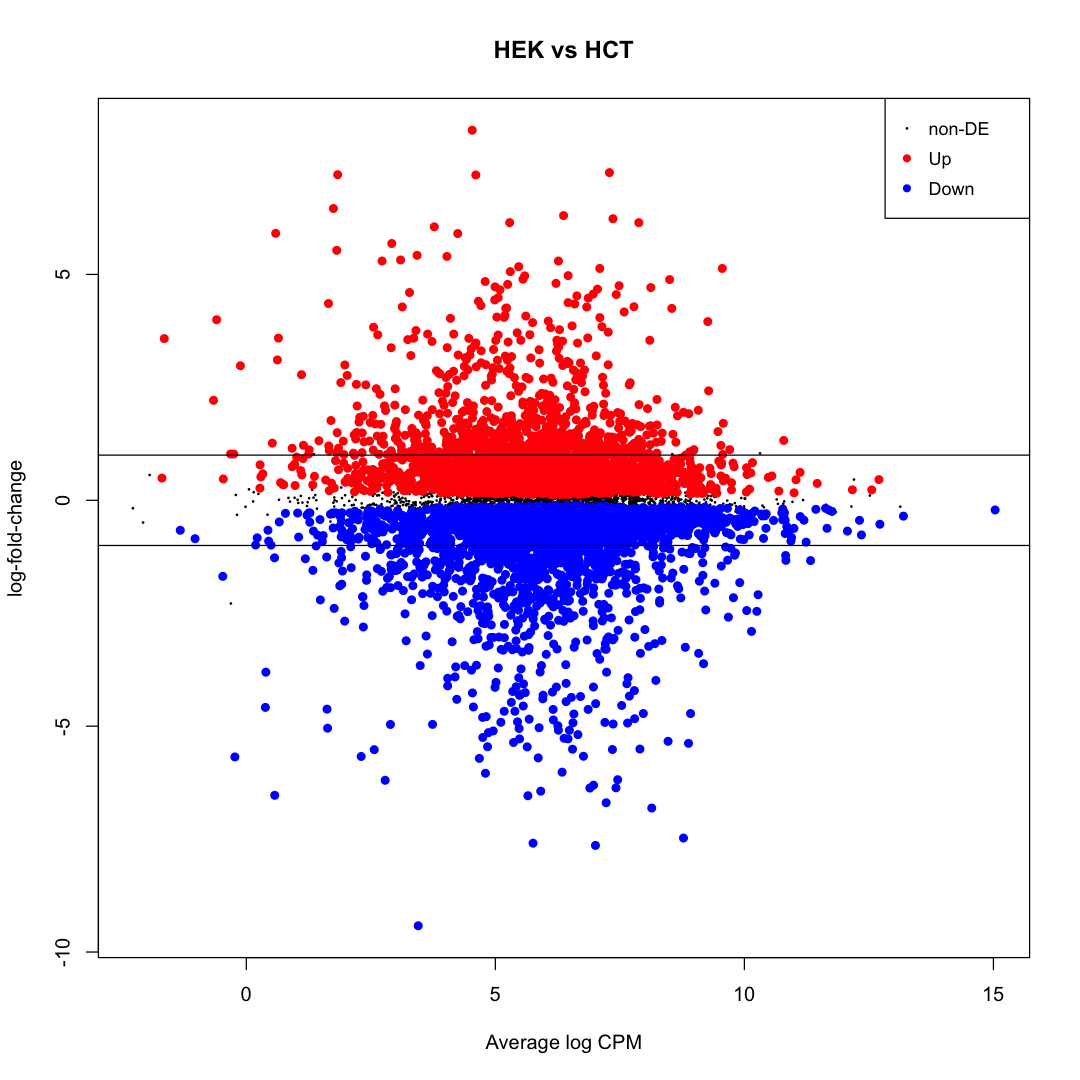

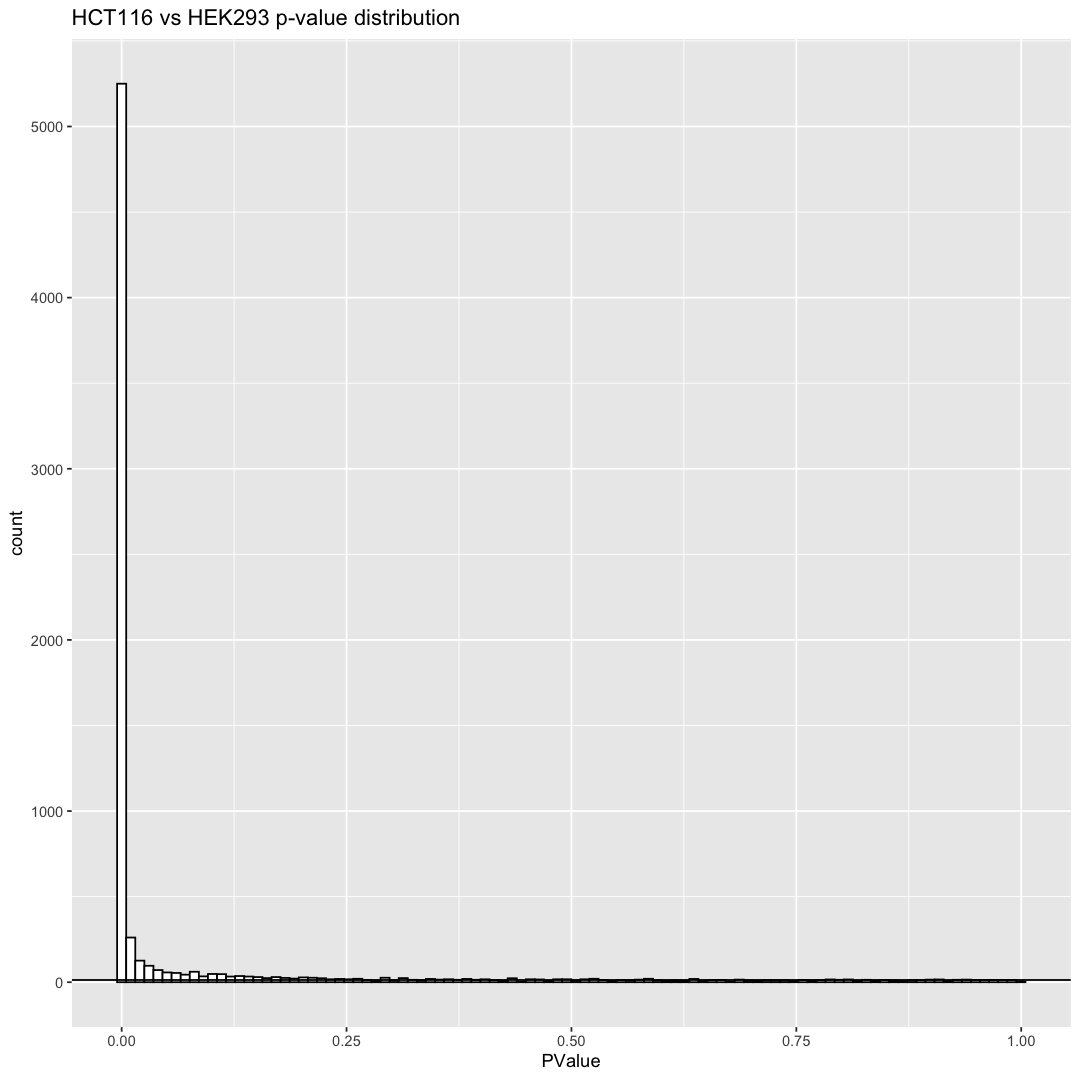

In [15]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("HCT", "HEK"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.05))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.05)
abline(h = c(-1, 1), col = "black") # 2-fold change lines

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("HCT116 vs HEK293 p-value distribution")

### We have 77% of the proteins as candidates

We have a similar, large number of DE candidates in this comparison. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [16]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, HCT, "HCT", HEK, "HEK")

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_HCT_HEK")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high      5331
2 med        431
3 low        221
4 no        1486

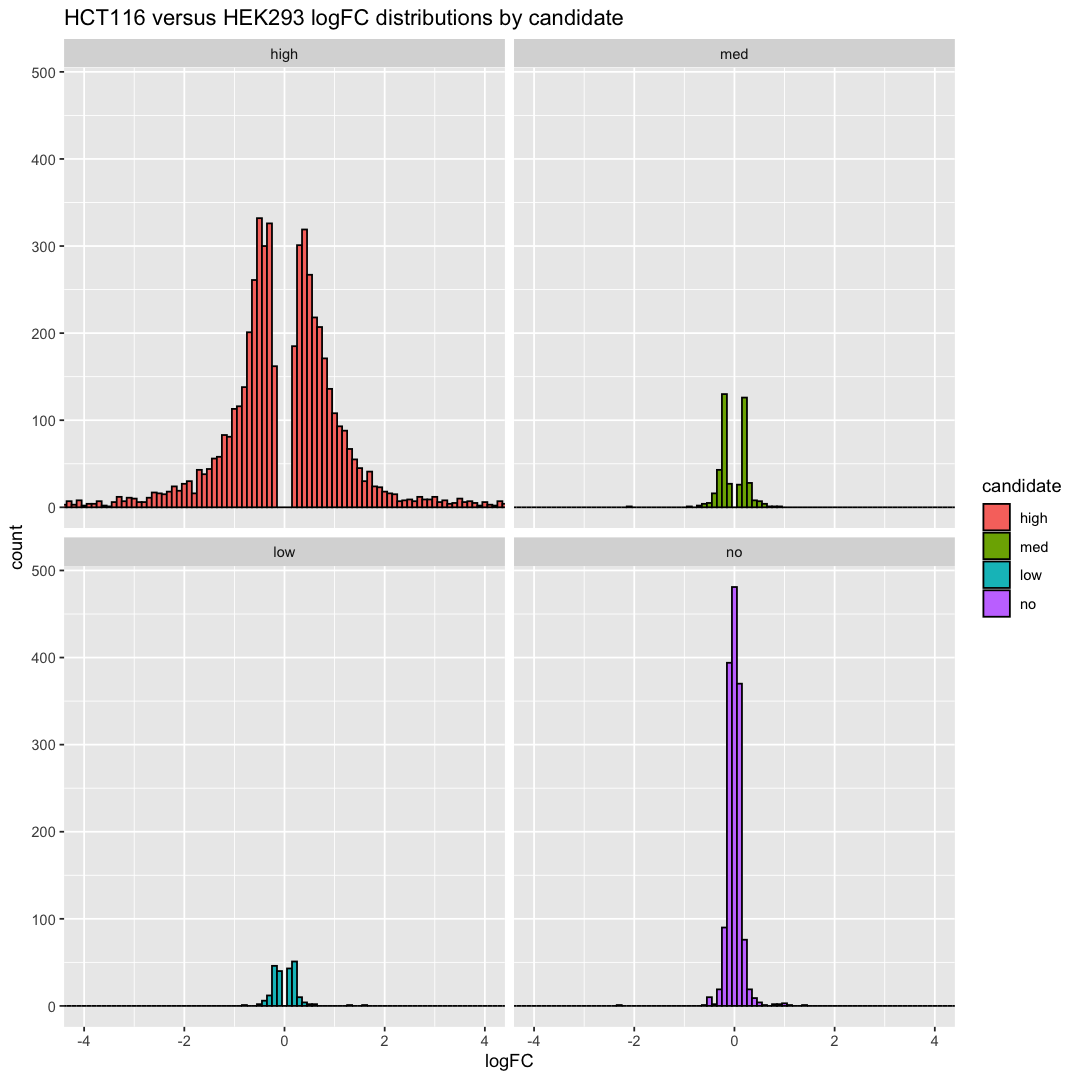

In [17]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("HCT116 versus HEK293 logFC distributions by candidate")

### MA plots

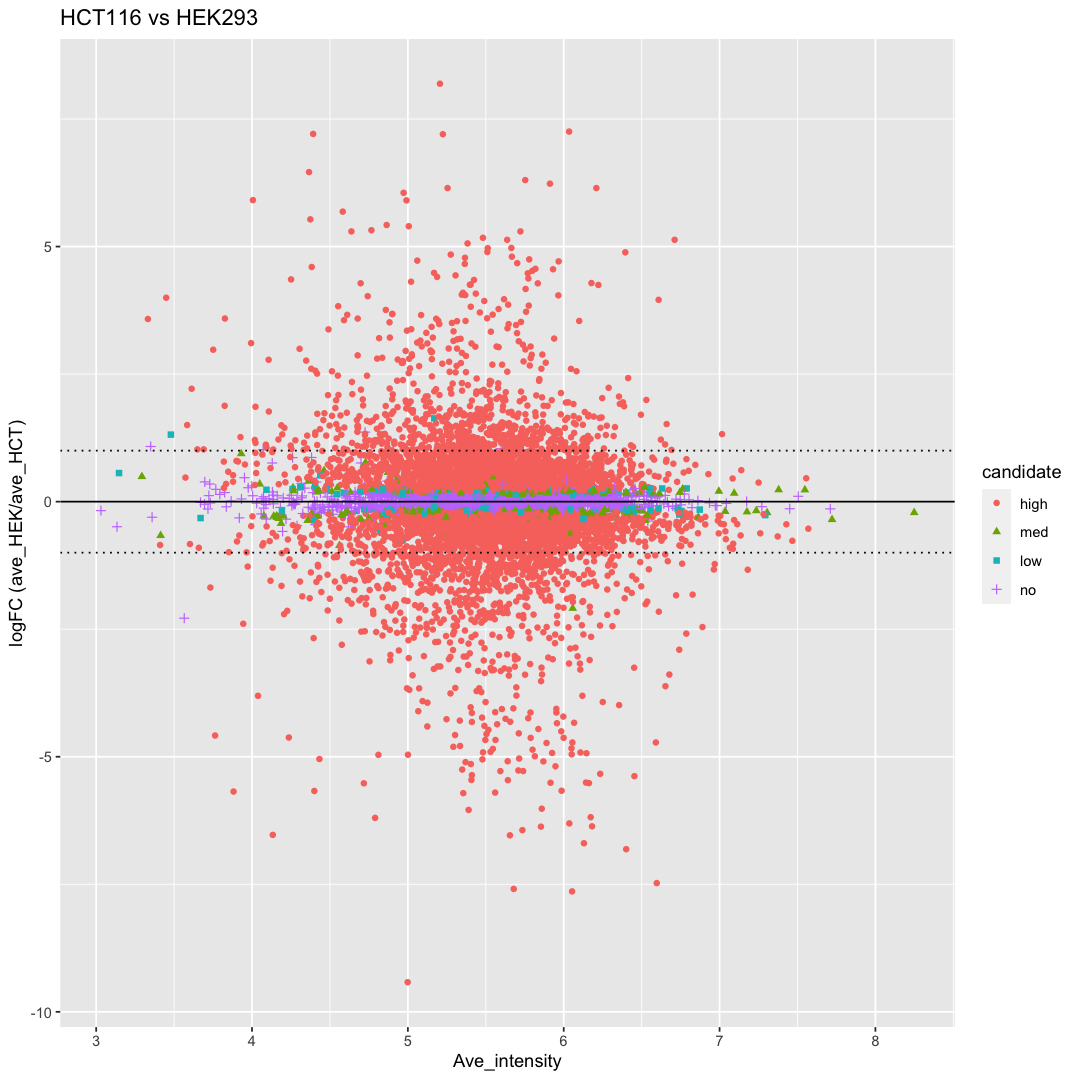

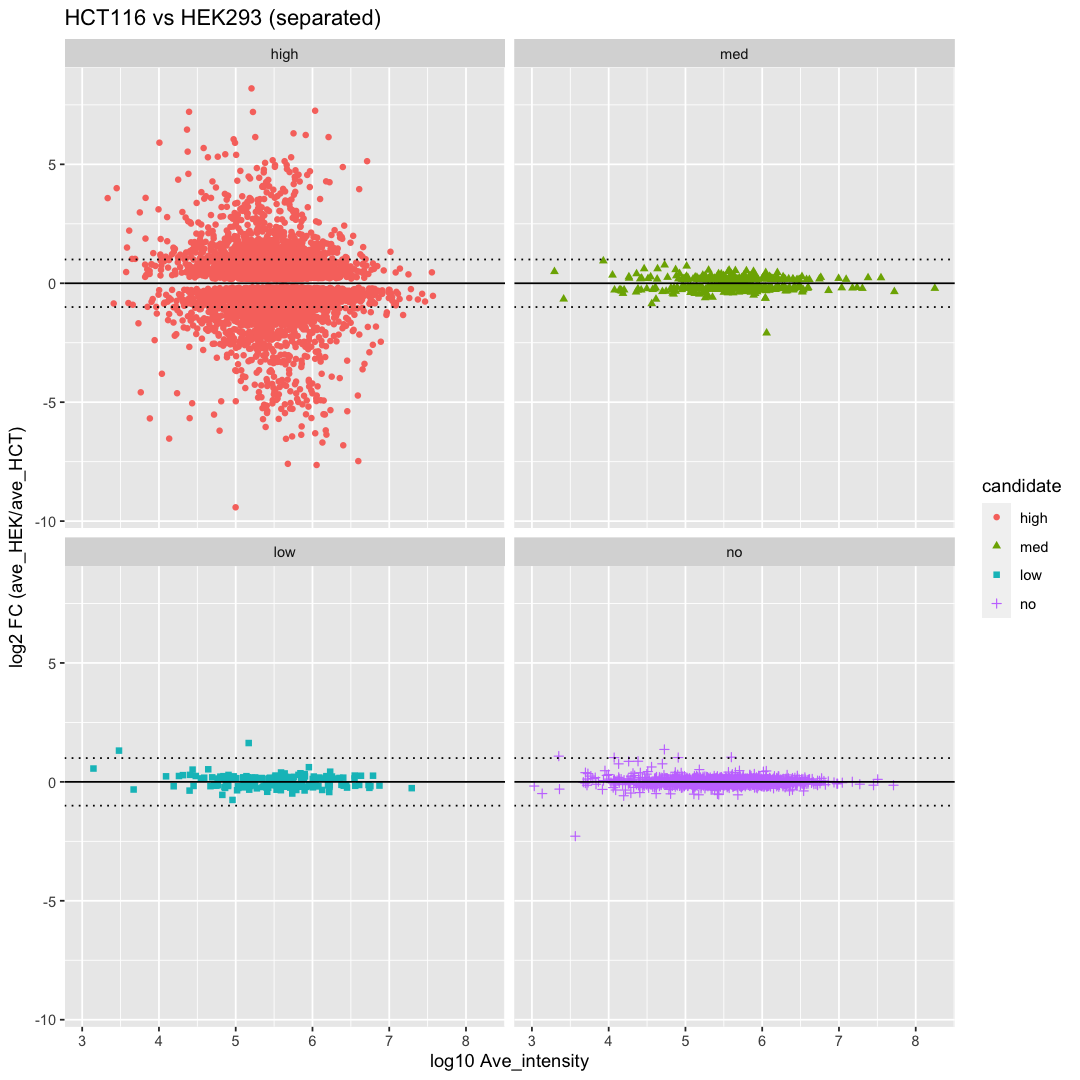

In [18]:
# make MA plots
MA_plots(results, "ave_HCT", "ave_HEK", "HCT116 vs HEK293")

### Scatter plots

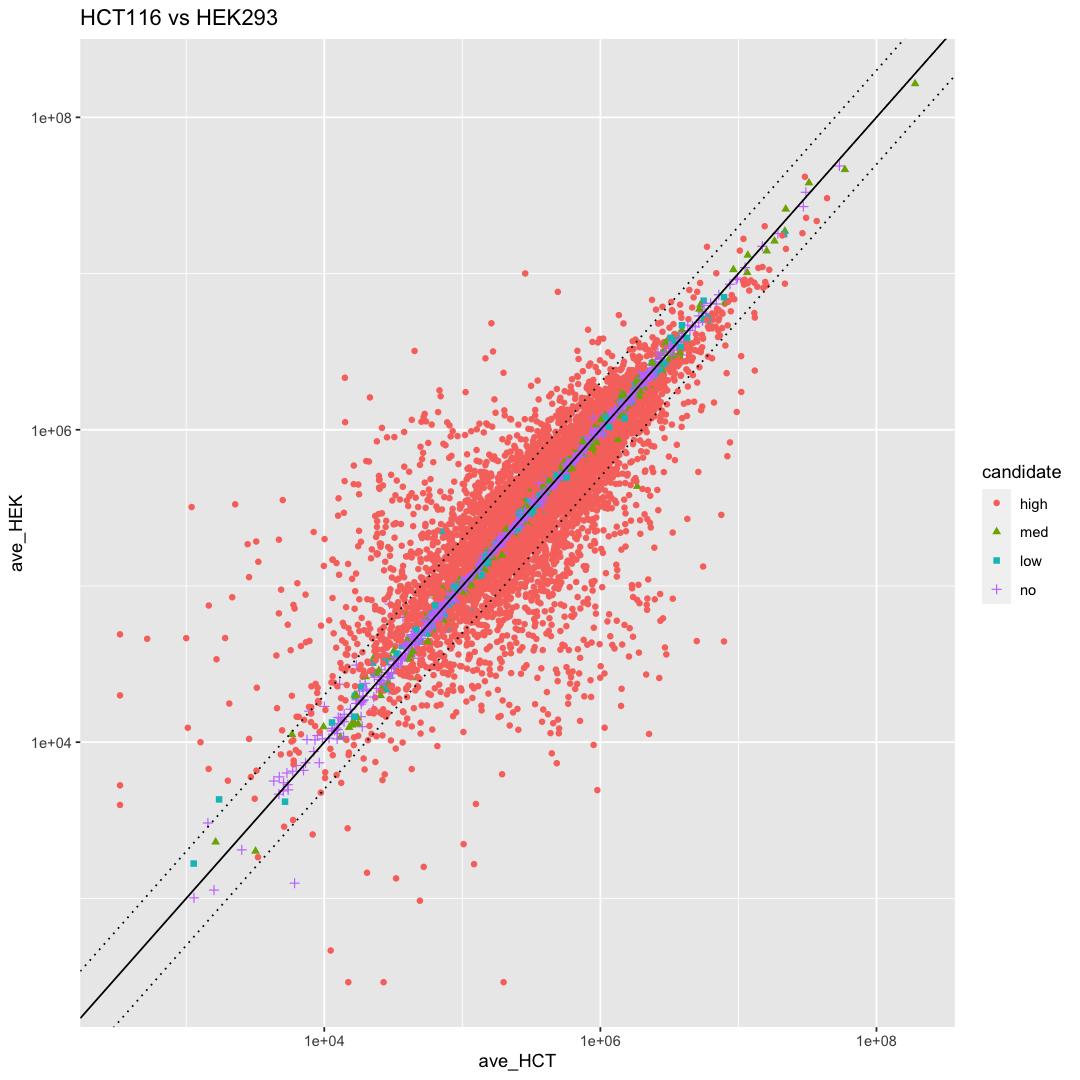

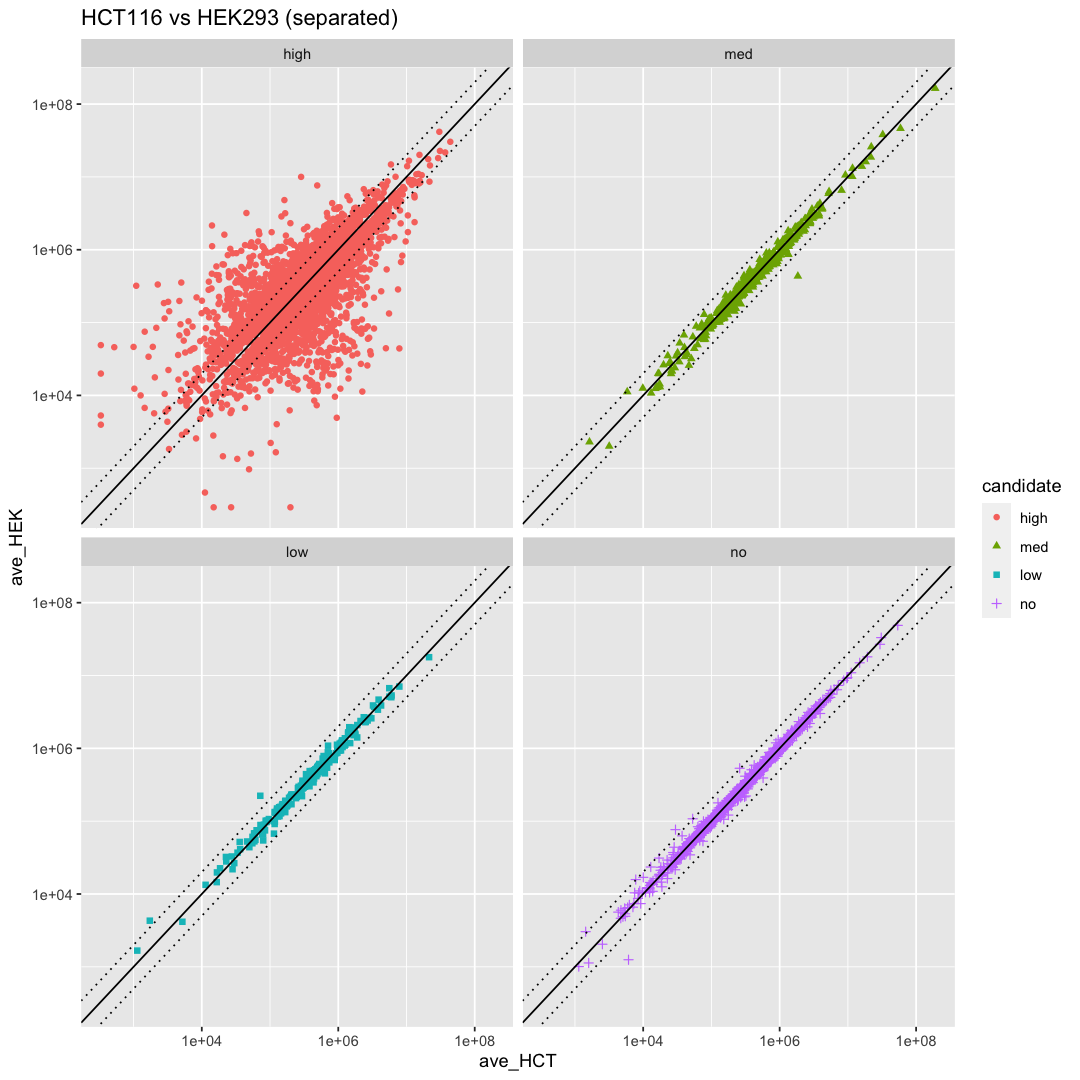

In [19]:
# make scatter plots
scatter_plots(results,  "ave_HCT", "ave_HEK", "HCT116 vs HEK293")

### Volcano plot

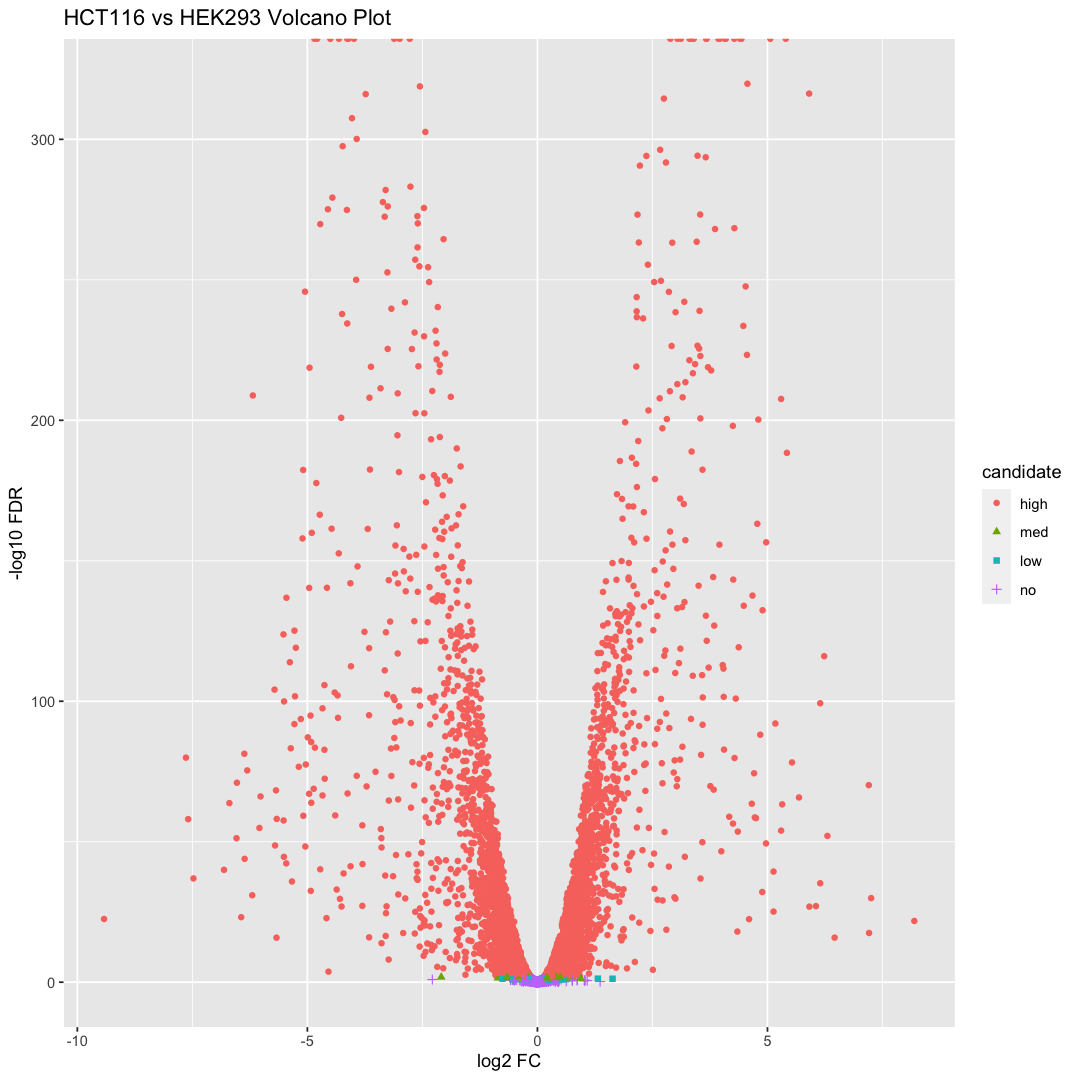

In [20]:
# make a volcano plot
volcano_plot(results, "ave_HCT", "ave_HEK", "HCT116 vs HEK293")

In [21]:
# count proteins with FC more than 2-fold
nrow(filter(results, abs(FC) > 2 & candidate != "no"))

[1] 1583

### Many candidates have larger fold-changes

The expression pattern is similar to the HCT116 versus MCF7 cells. We might have more proteins with some larger fold-changes in this comparison of HCT116 cells to HEK293 cells.

### Check some individual protein expression

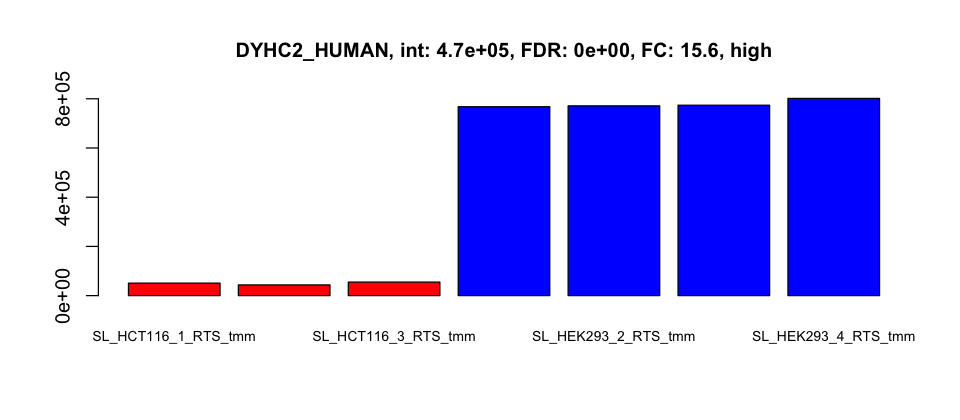

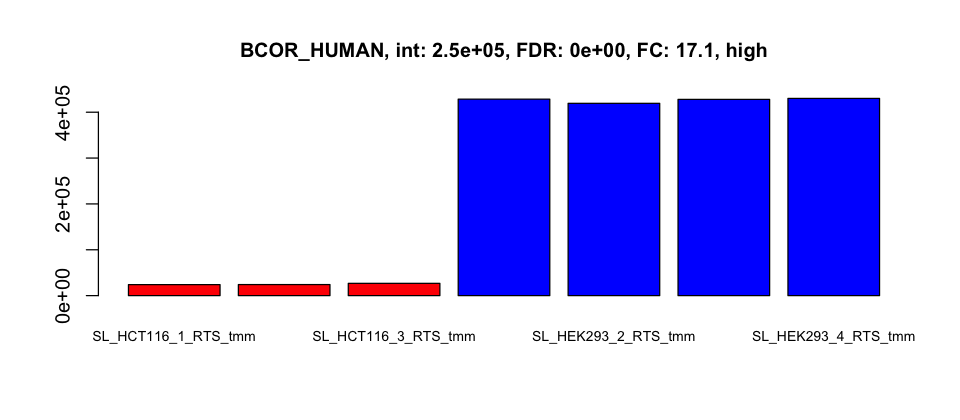

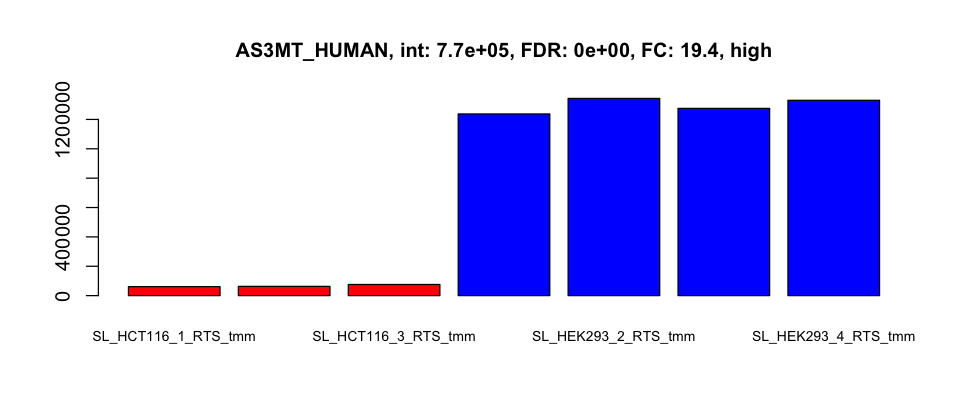

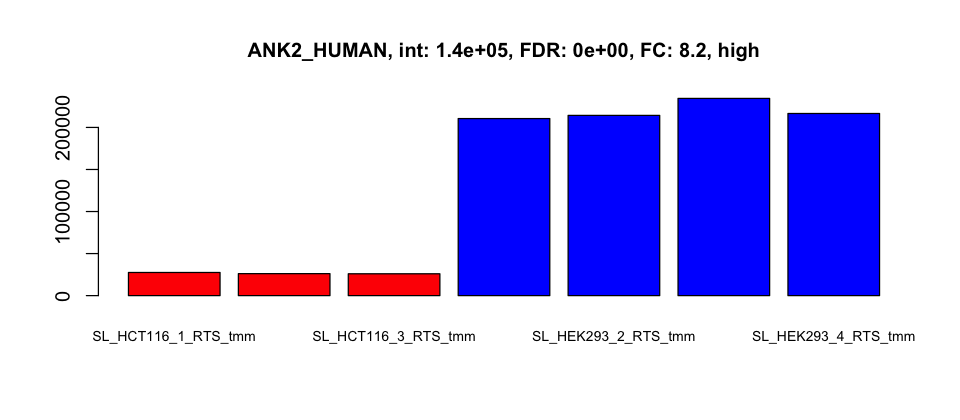

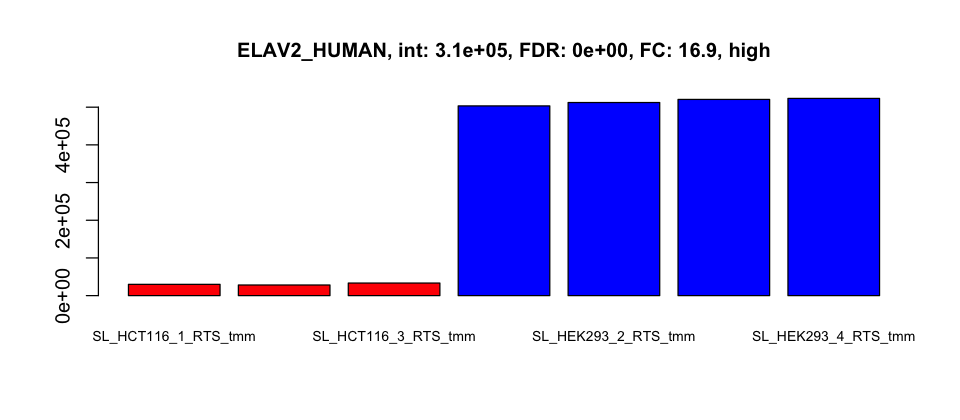

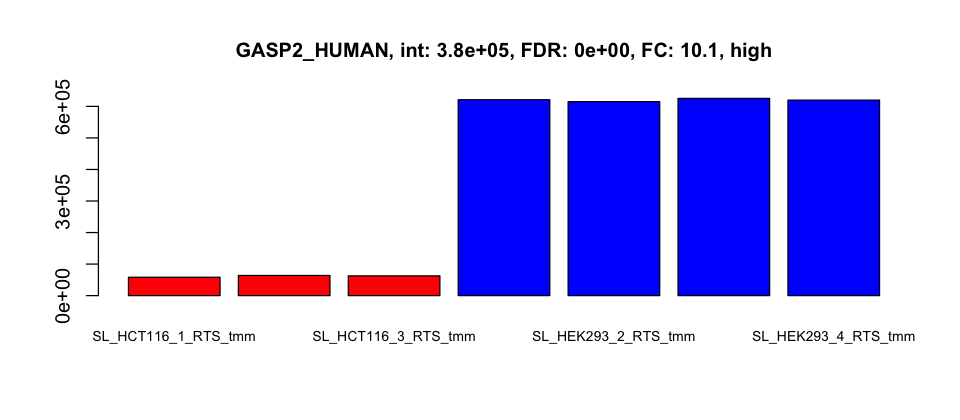

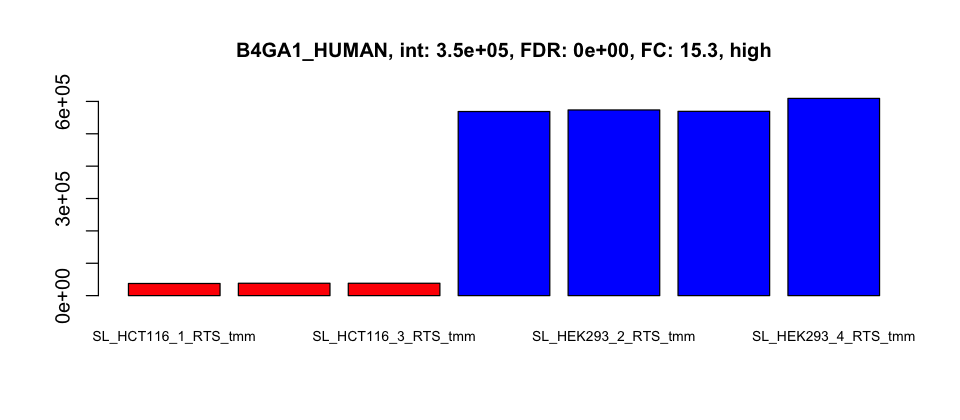

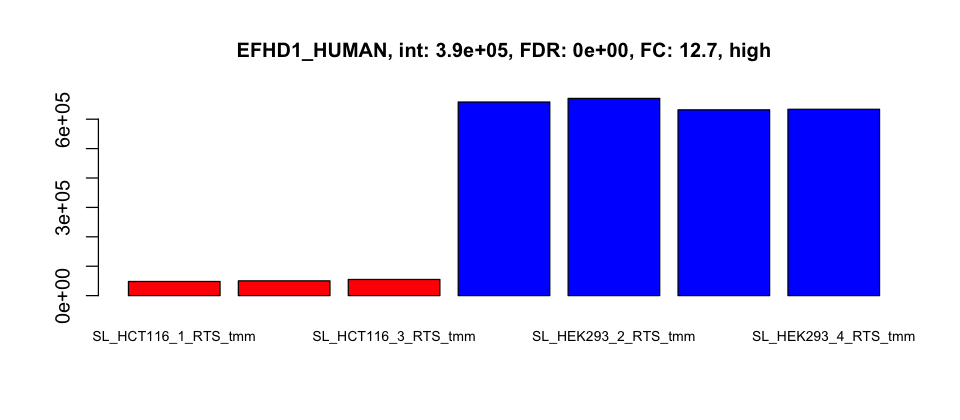

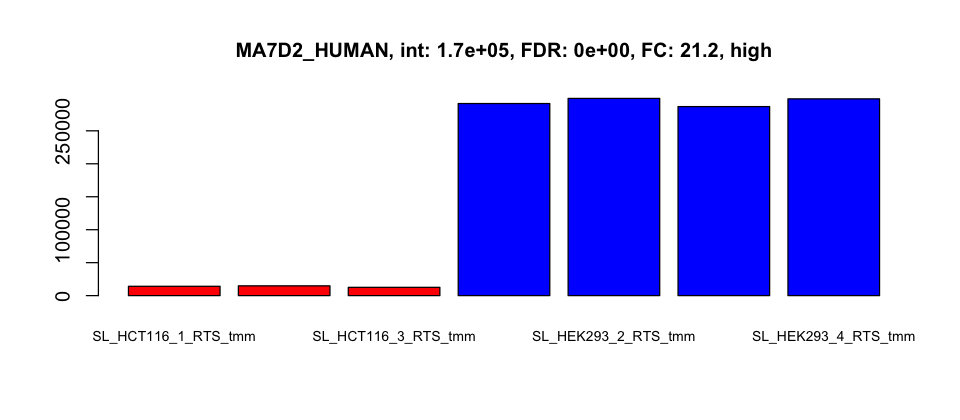

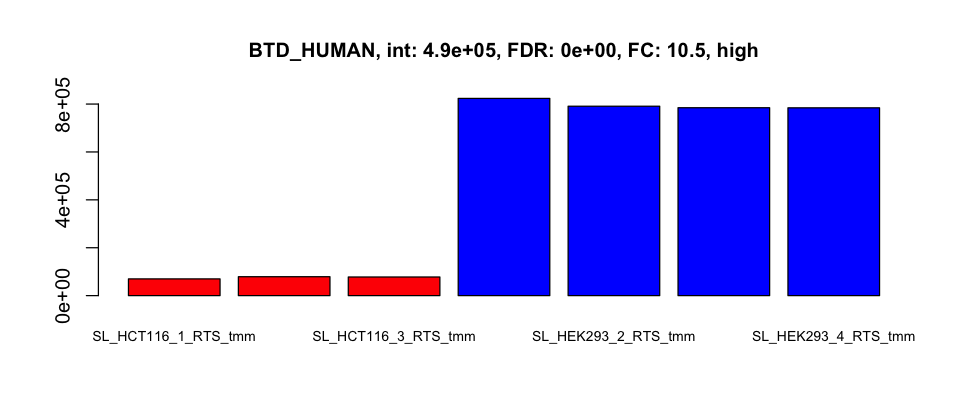

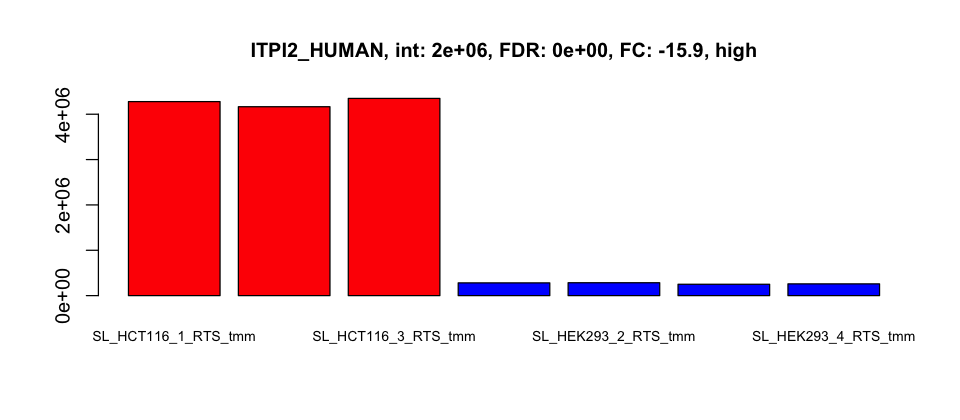

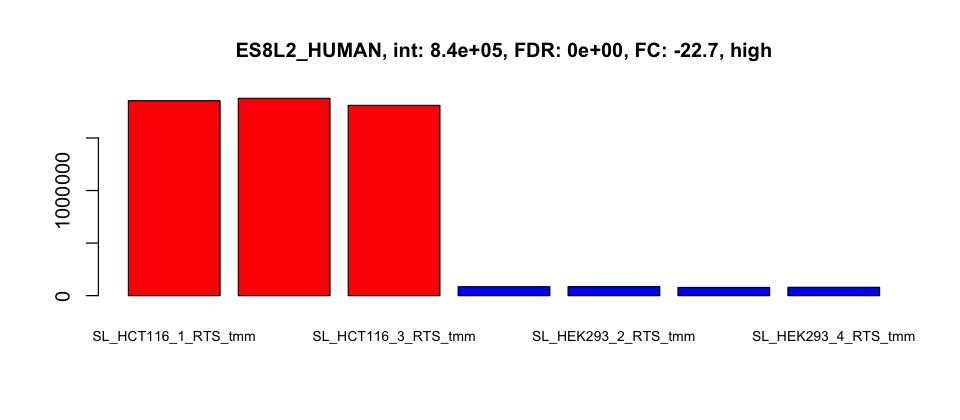

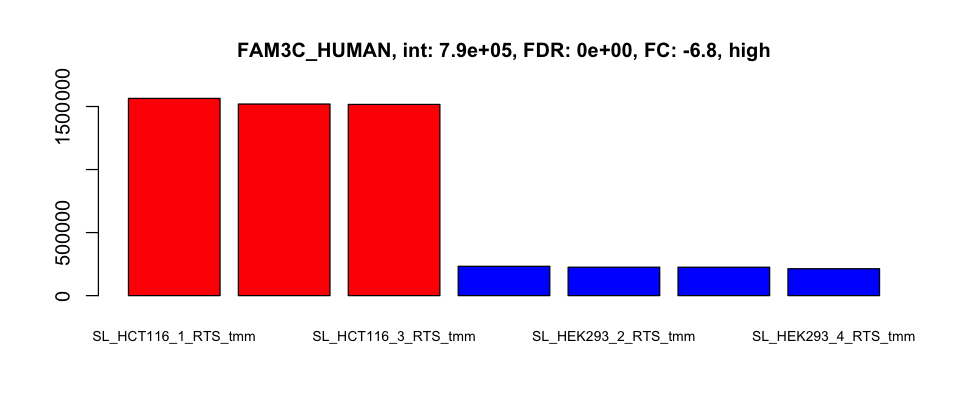

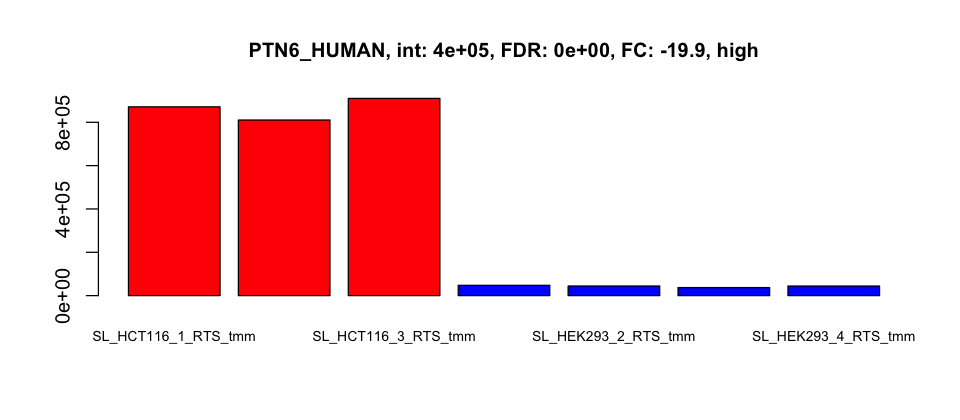

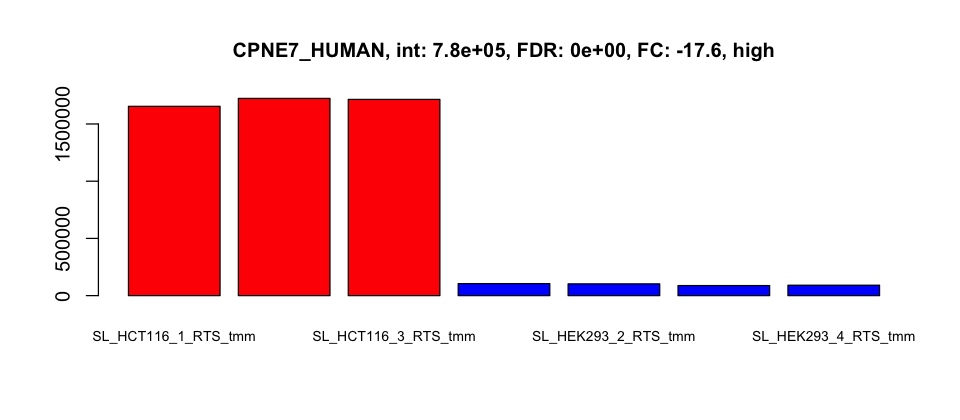

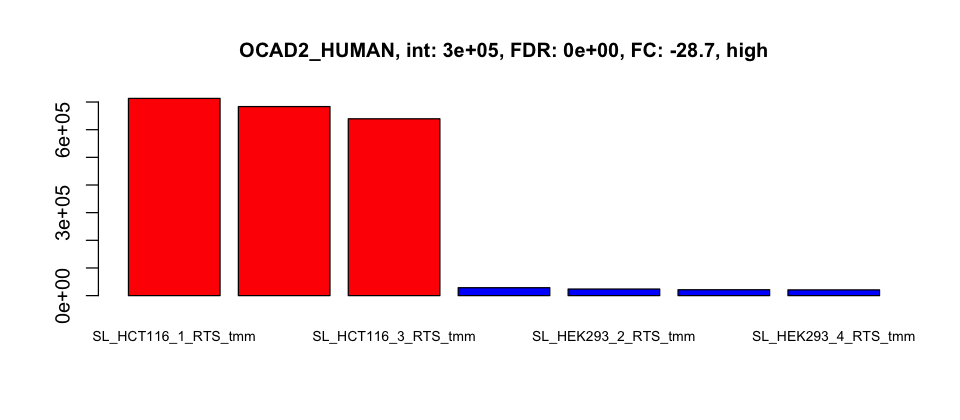

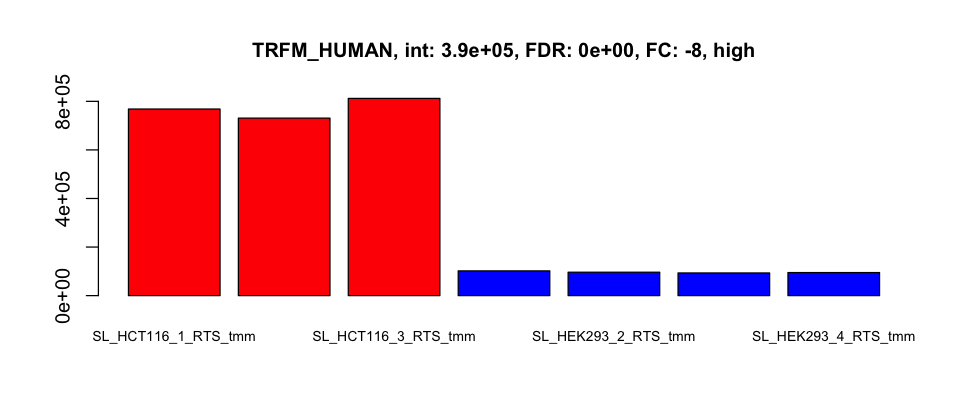

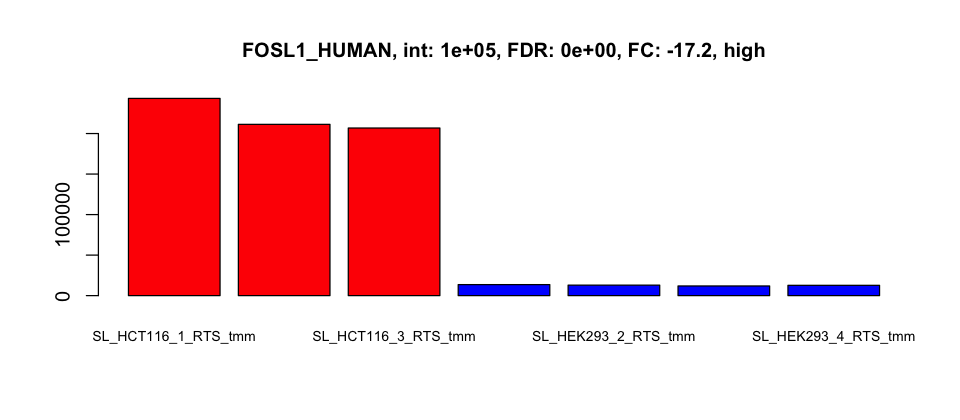

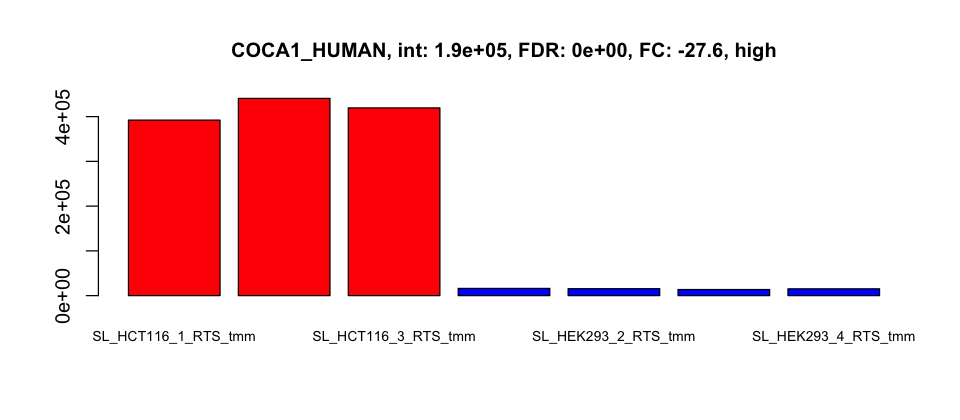

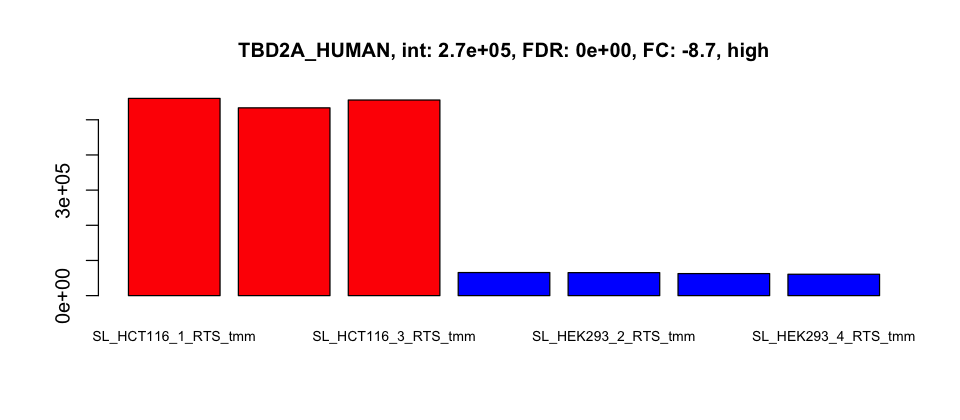

In [22]:
# look at the top candidates
set_plot_dimensions(8, 3.5)
plot_top_tags(results, 3, 4, 10)
set_plot_dimensions(9, 9)

### Individual candidates are solid

We have very small p-values, large fold changes, and low variance like the first comparison.

----

## (3) MCF7 versus HEK293

Compare the MCF7 cells to the HEK293 cells.

       HEK-MCF
Down      2952
NotSig    1535
Up        2982

genes                 logFC     logCPM   PValue        FDR          
5758 sp|Q8NDH3|PEPL1_HUMAN -4.072179 5.990006  0.000000e+00  0.000000e+00
4730 sp|Q9BUP0|EFHD1_HUMAN  3.671772 5.692474  0.000000e+00  0.000000e+00
5751 sp|Q11201|SIA4A_HUMAN -3.000319 5.511281  0.000000e+00  0.000000e+00
1818 sp|O00178|GTPB1_HUMAN  2.618914 5.995608  0.000000e+00  0.000000e+00
2226 sp|Q6YP21|KAT3_HUMAN   2.579135 6.180456  0.000000e+00  0.000000e+00
3723 sp|Q16527|CSRP2_HUMAN  3.280415 5.313466 3.003919e-321 3.739380e-318
3884 sp|P23508|CRCM_HUMAN  -2.281705 5.856579 1.971055e-289 2.103116e-286
5877 sp|O00562|PITM1_HUMAN -2.436635 5.566068 3.871931e-282 3.614932e-279
3309 sp|Q7Z6K5|ARPIN_HUMAN  2.167301 6.014764 1.271967e-265 1.055591e-262
1155 sp|P43304|GPDM_HUMAN  -2.261488 5.725676 1.136456e-250 8.488189e-248

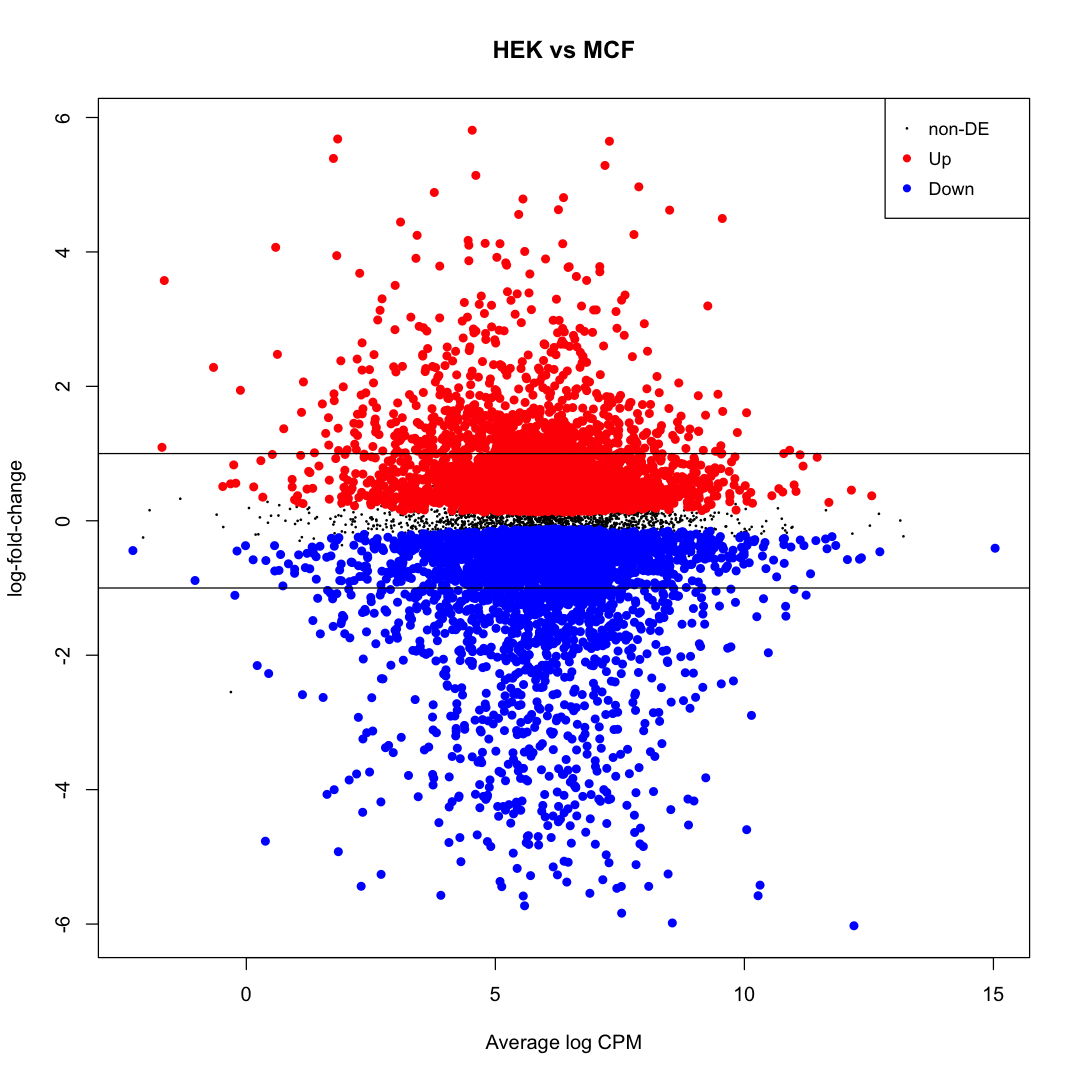

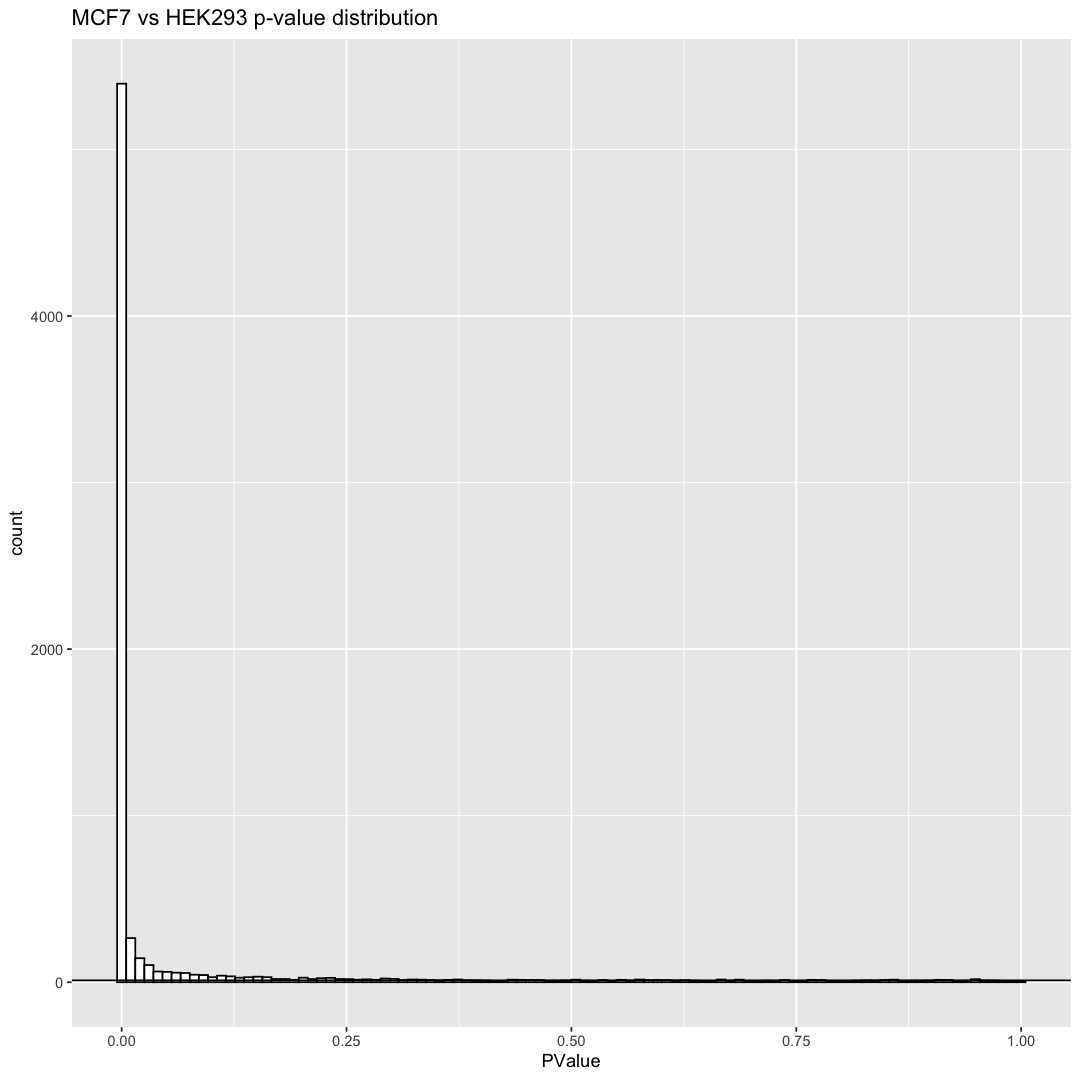

In [23]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("MCF", "HEK"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.05))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.05)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("MCF7 vs HEK293 p-value distribution")

### We have even more DE candidates  

We have almost 80% of the proteins differentially expressed for this comparison.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we have few candidates, we will still make the MA plot, scatter plot, and volcano plot.

In [24]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, MCF, "MCF", HEK, "HEK")

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_MCF_HEK")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high      5472
2 med        462
3 low        237
4 no        1298

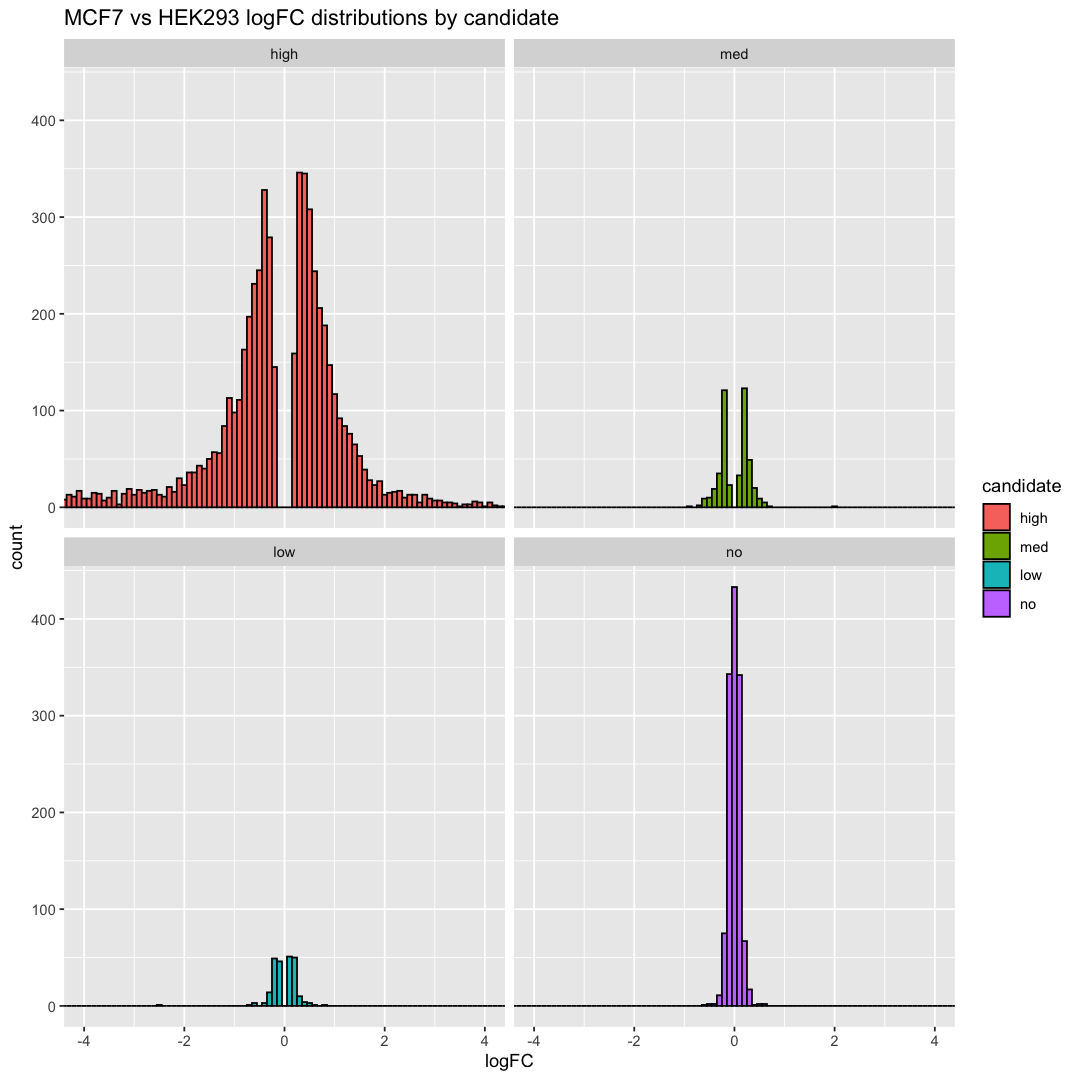

In [25]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("MCF7 vs HEK293 logFC distributions by candidate")

### MA plots

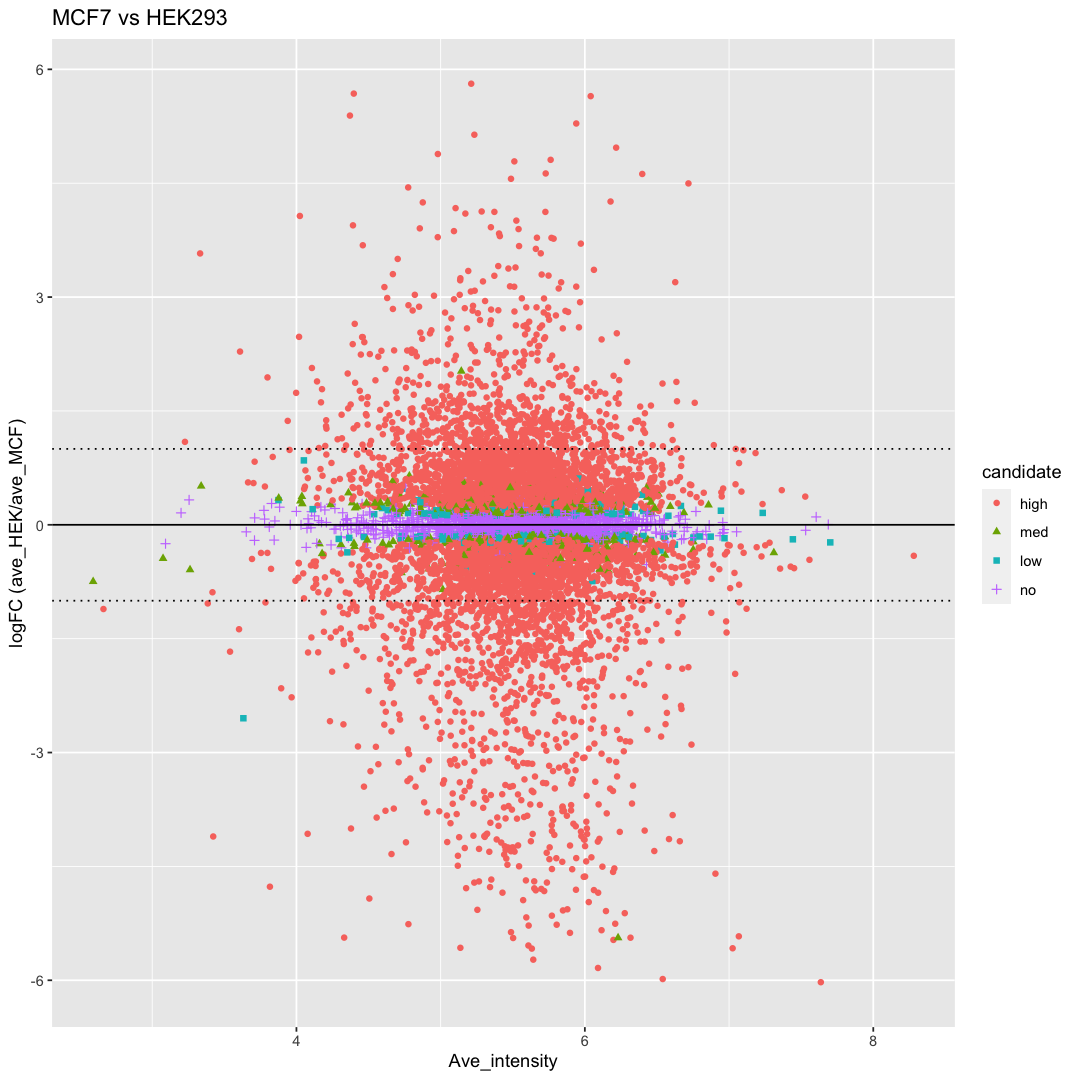

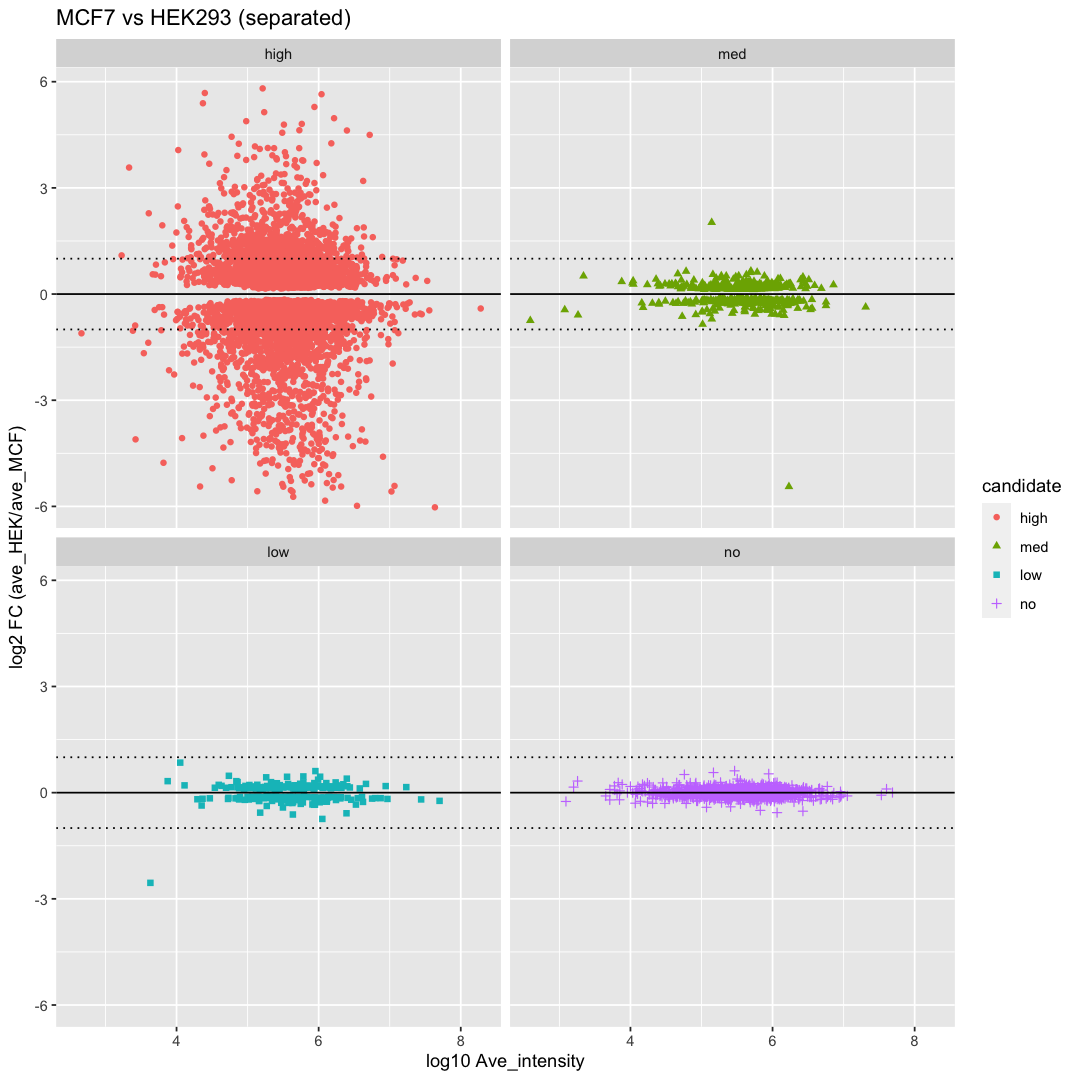

In [26]:
# make MA plots
MA_plots(results, "ave_MCF", "ave_HEK", "MCF7 vs HEK293")

### Scatter plots

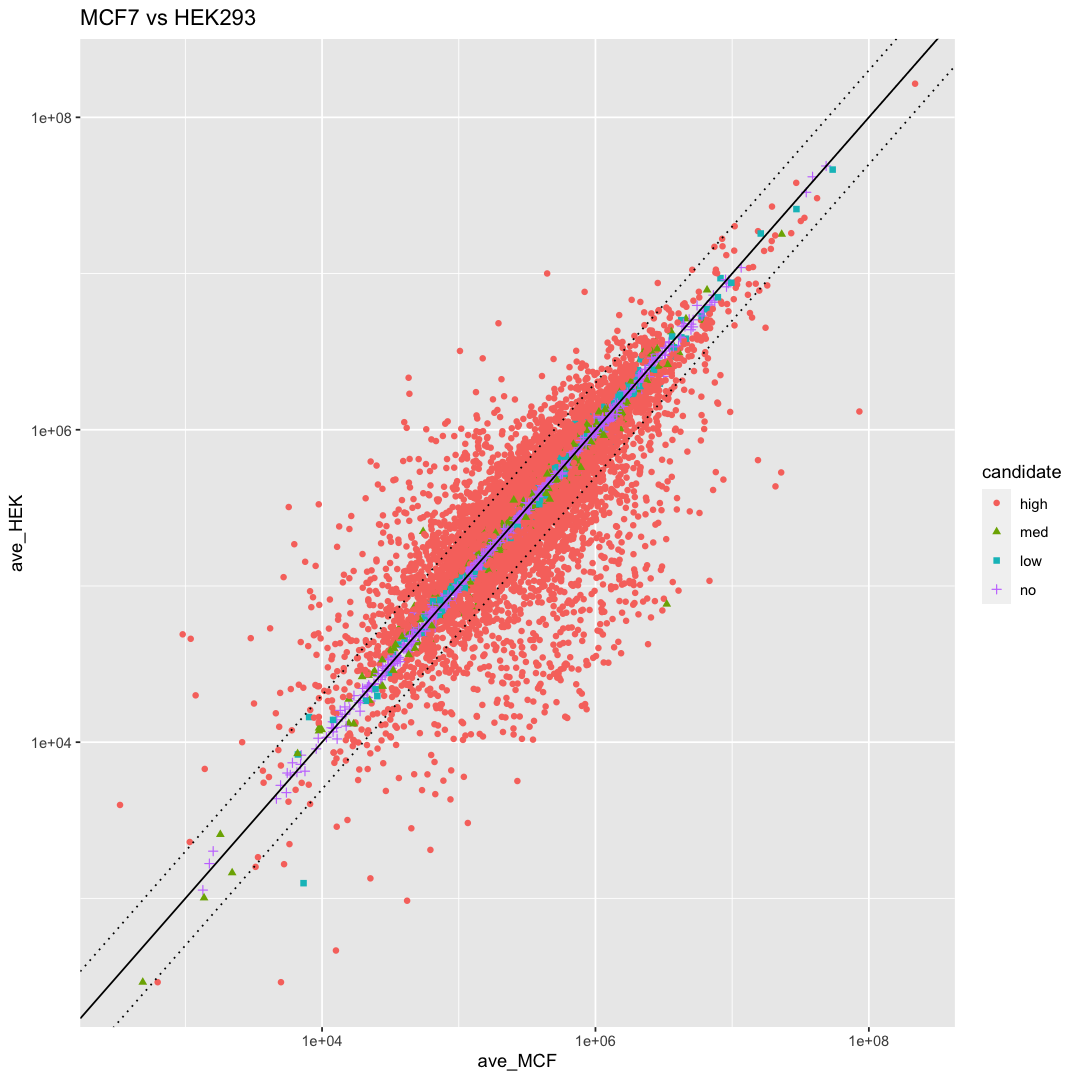

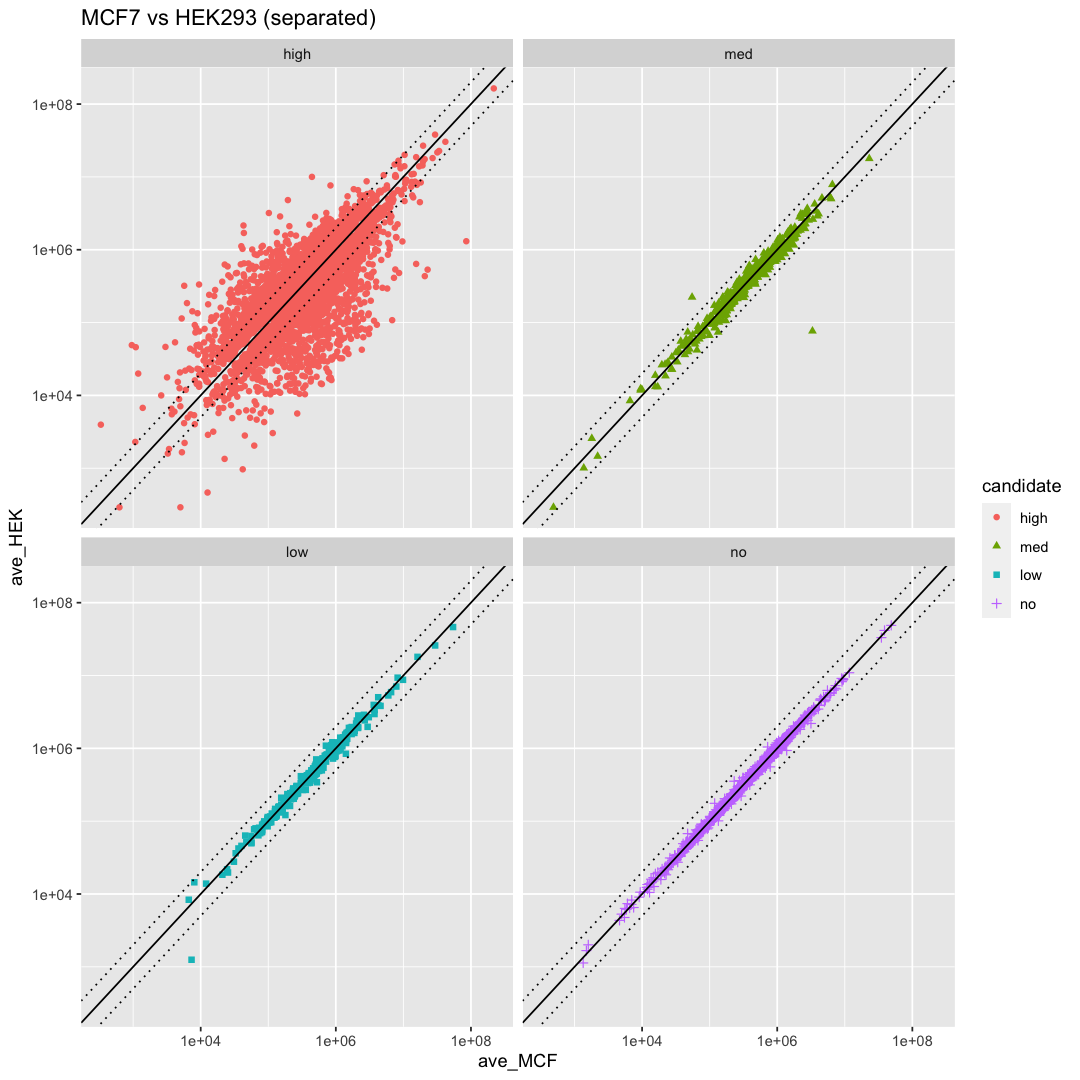

In [27]:
# make scatter plots
scatter_plots(results, "ave_MCF", "ave_HEK", "MCF7 vs HEK293")

### Volcano plot

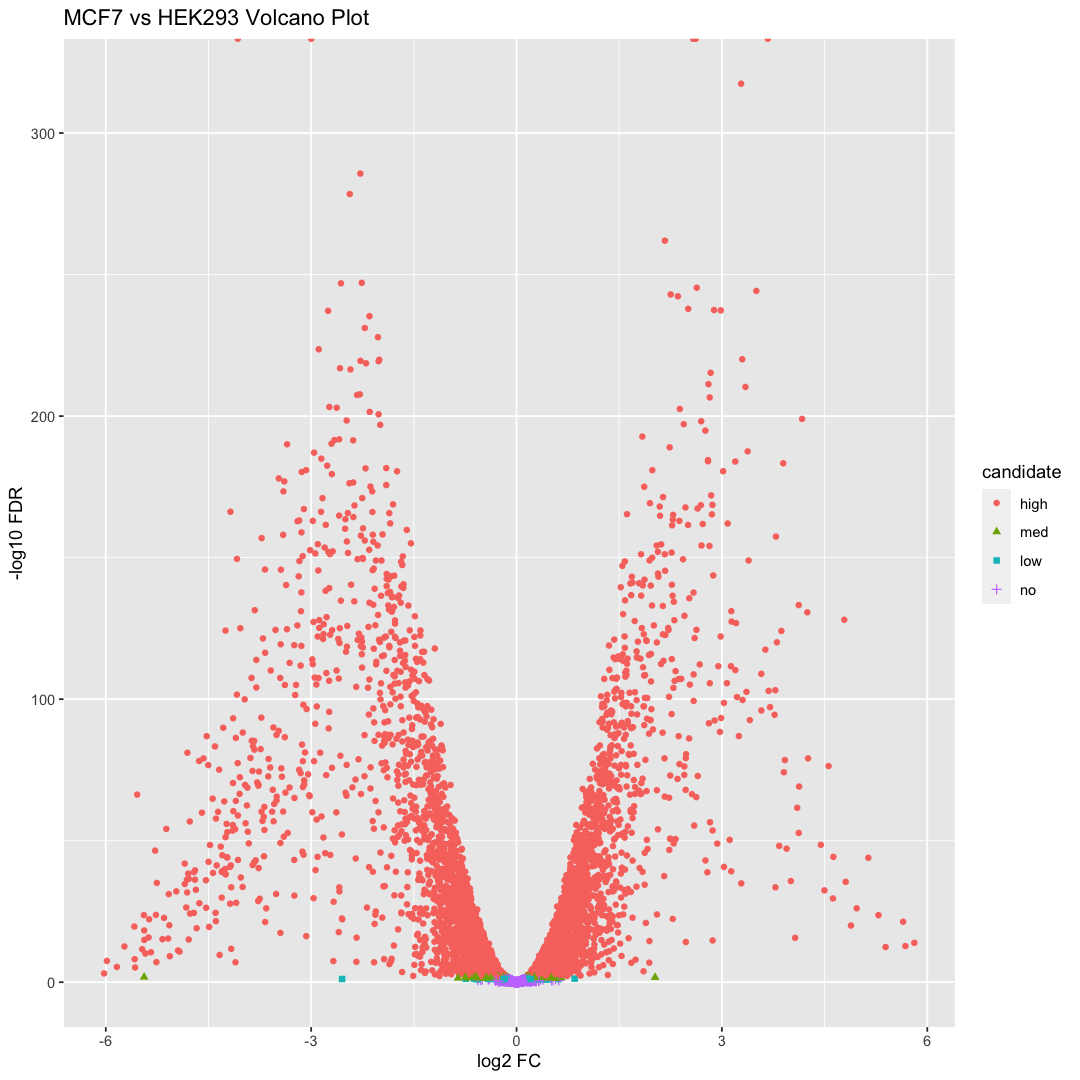

In [28]:
# make a volcano plot
volcano_plot(results, "ave_MCF", "ave_HEK", "MCF7 vs HEK293")

In [29]:
# count proteins with FC more than 2-fold
nrow(filter(results, abs(FC) > 2 & candidate != "no"))

[1] 1717

### Candidate visualization patterns are similar to other two comparisons

### Check individual protein expression

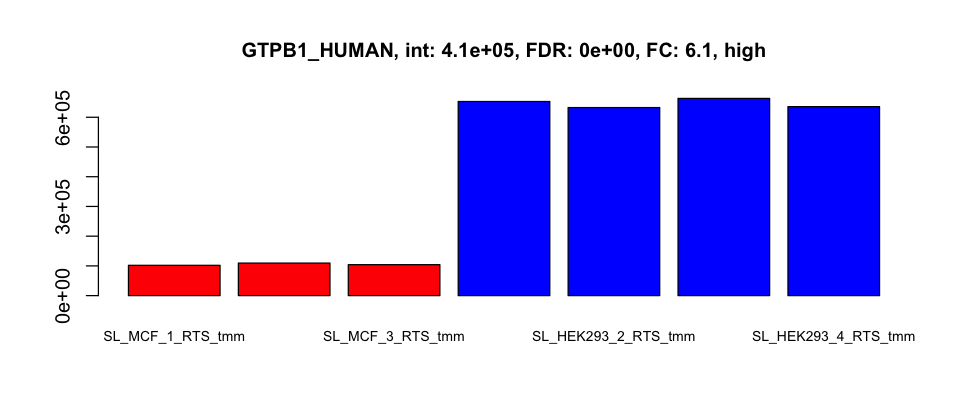

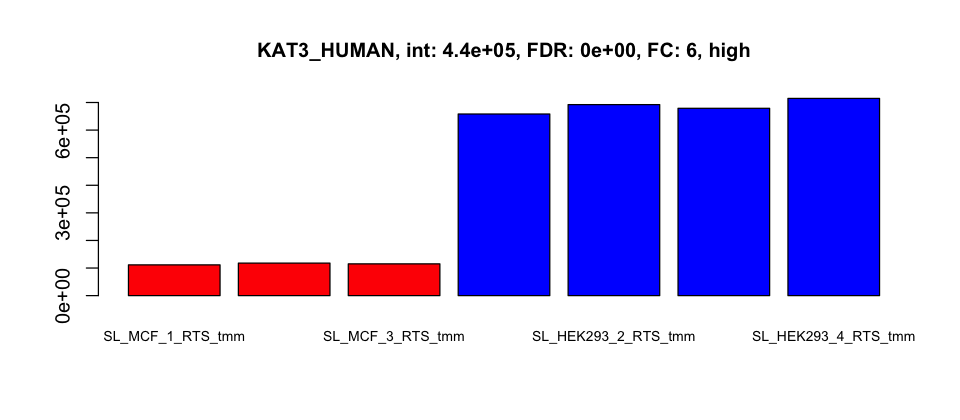

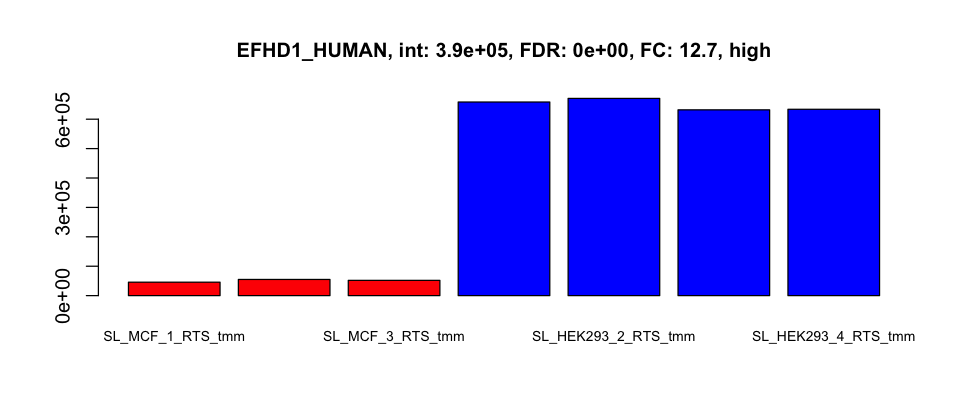

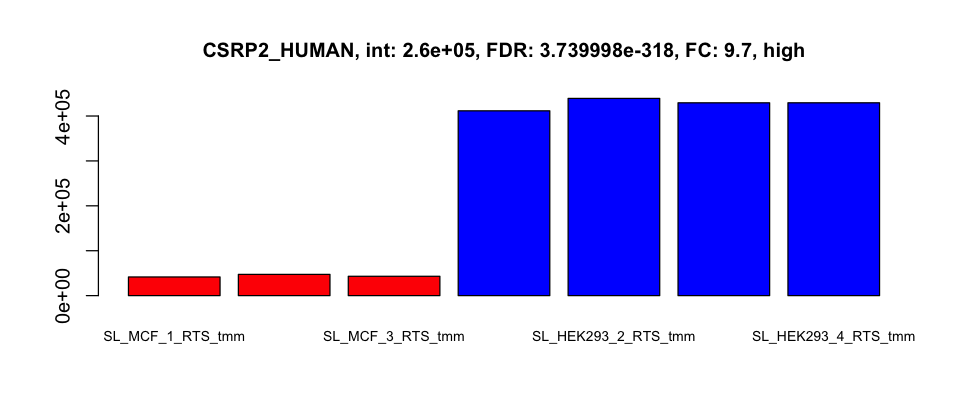

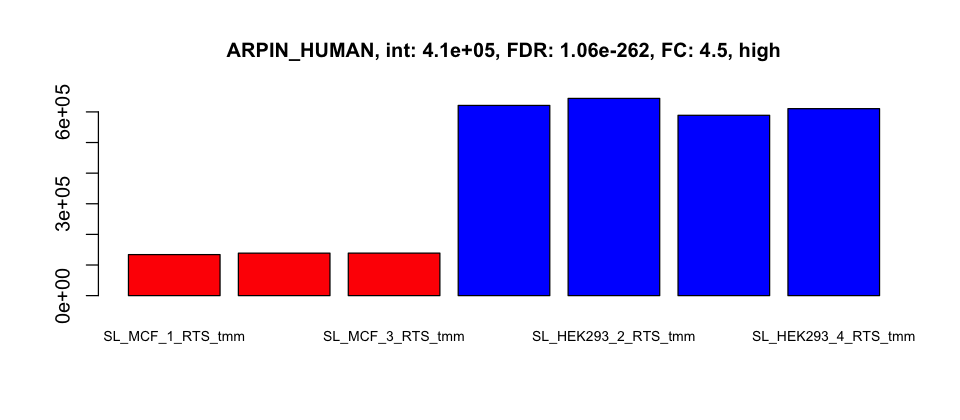

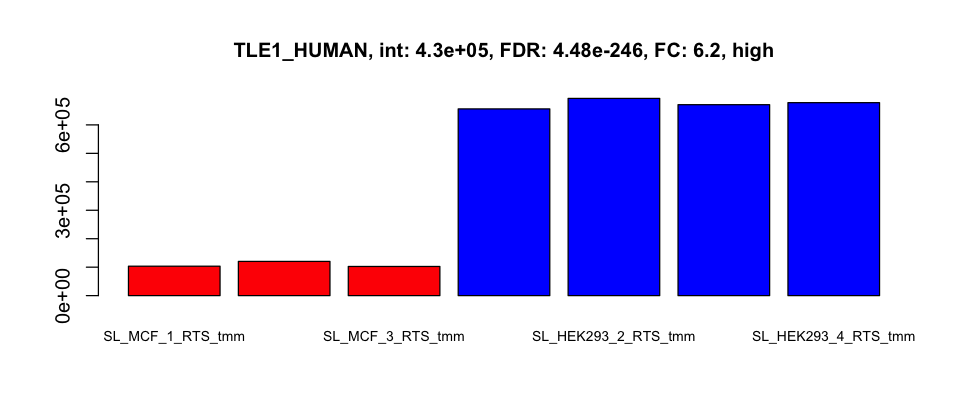

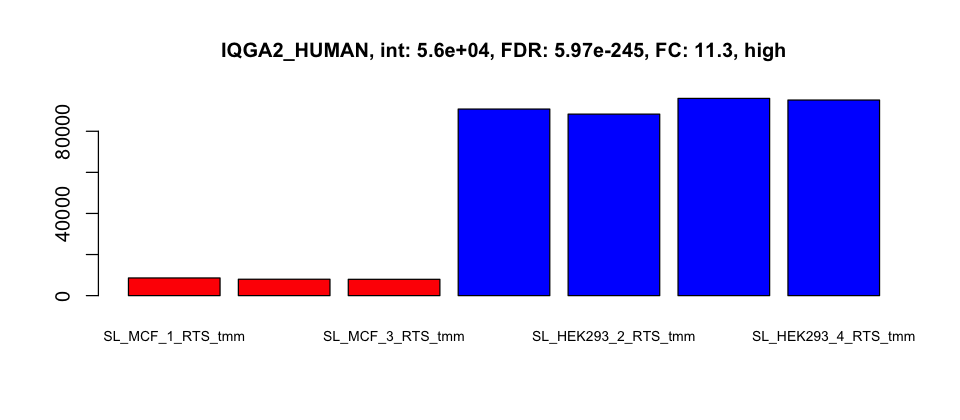

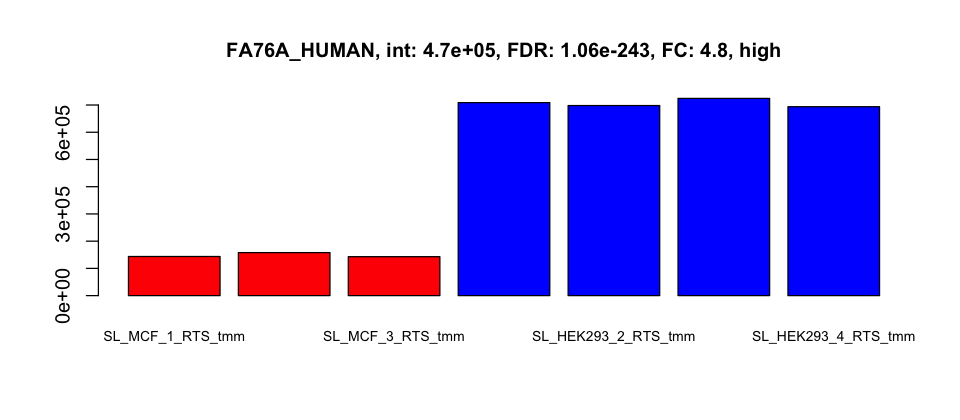

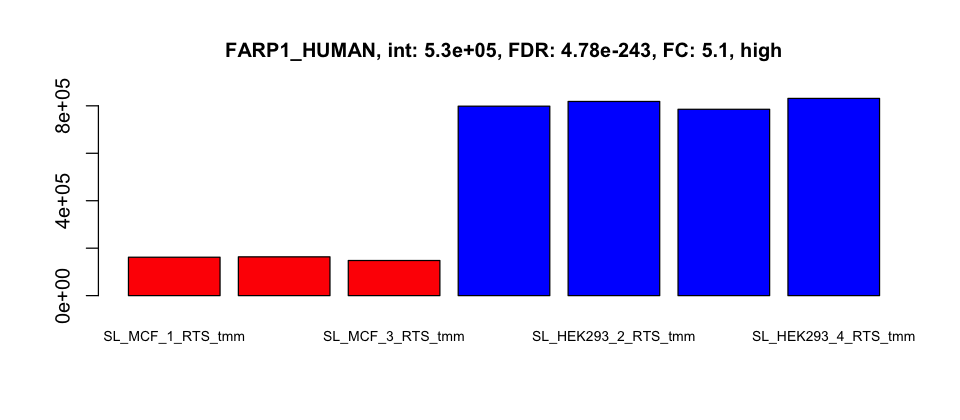

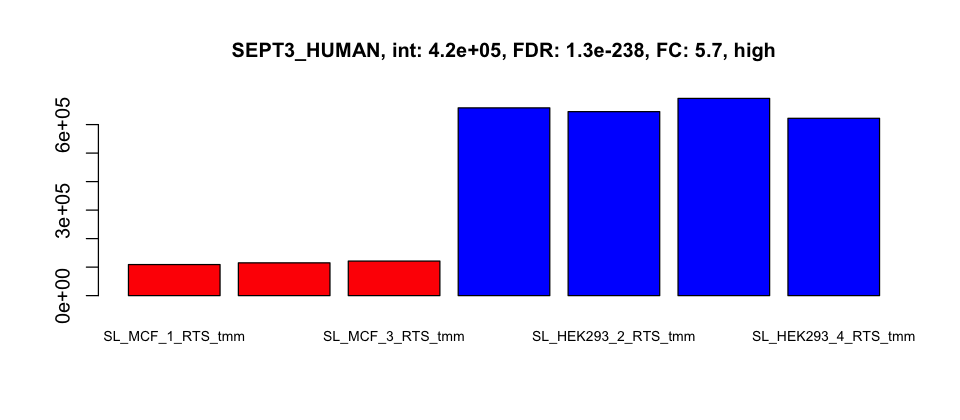

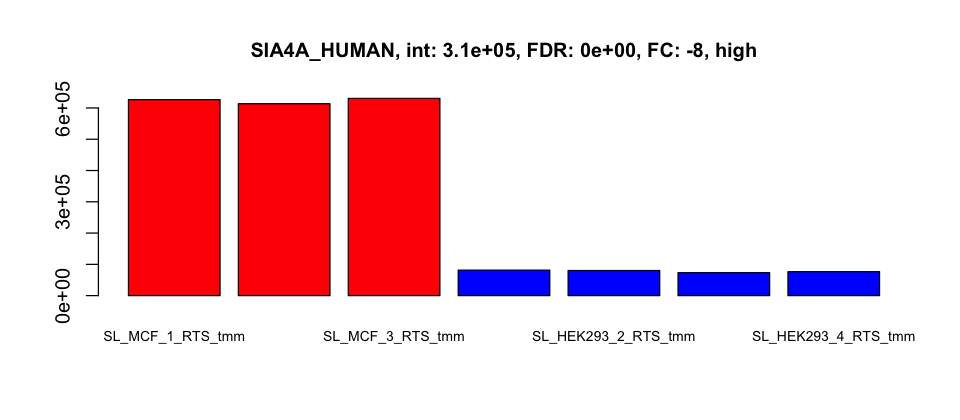

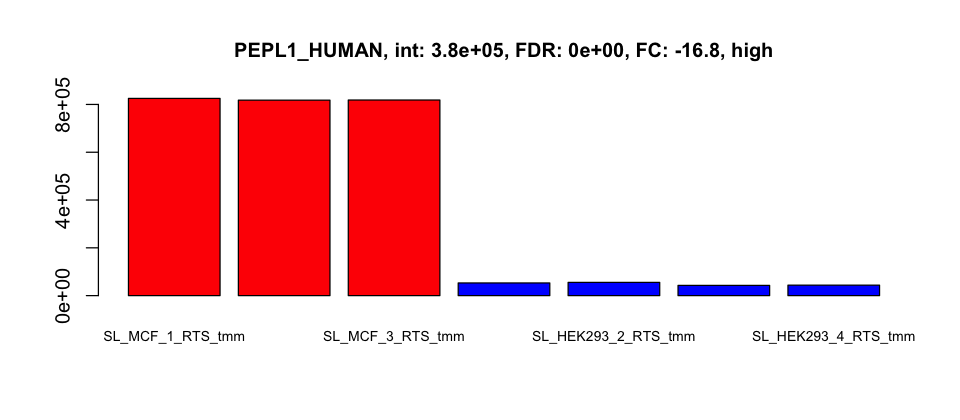

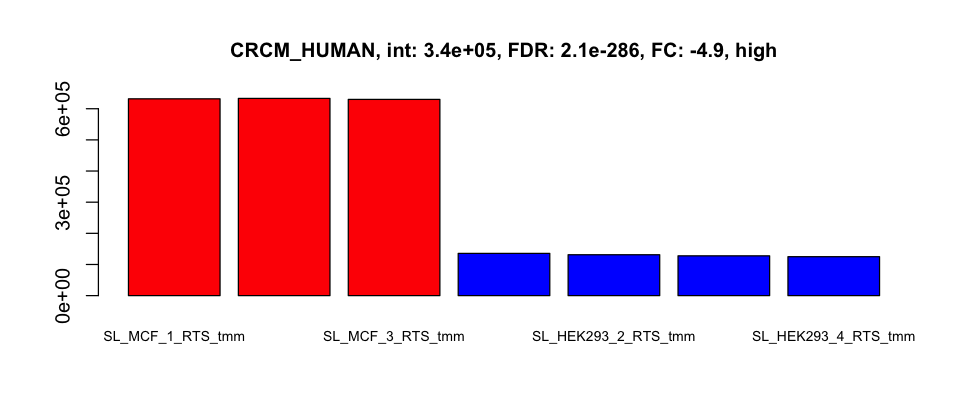

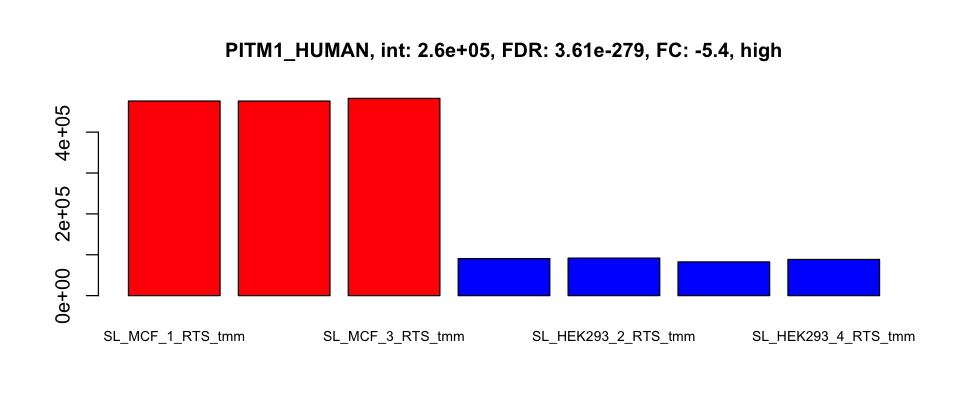

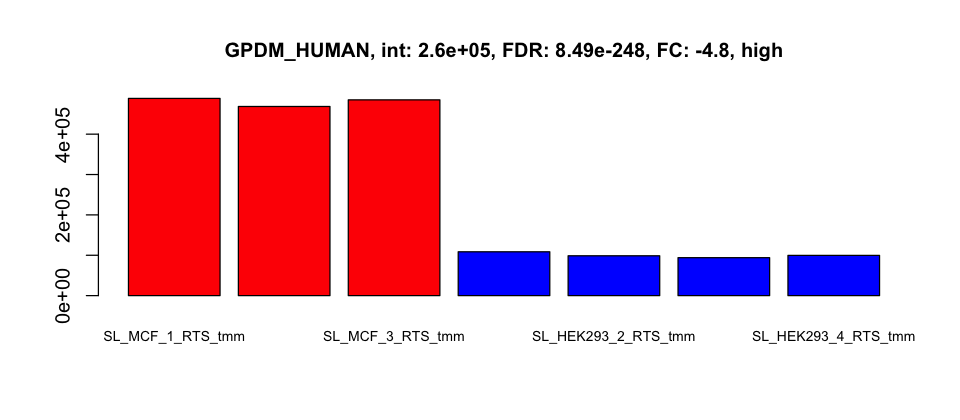

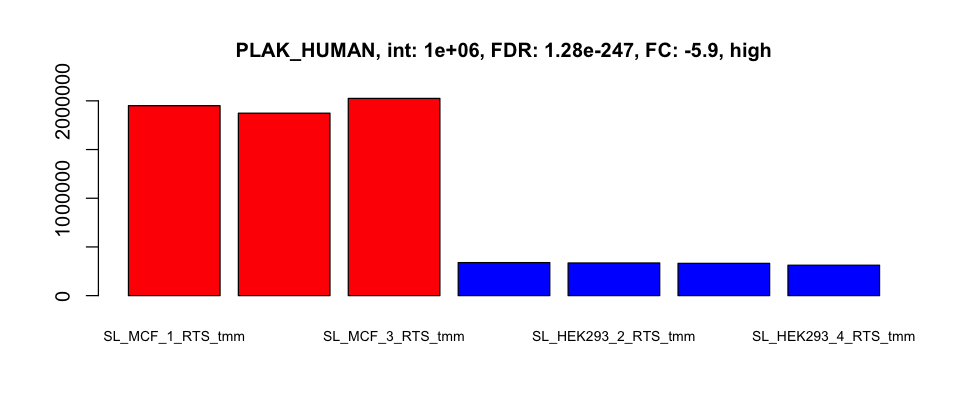

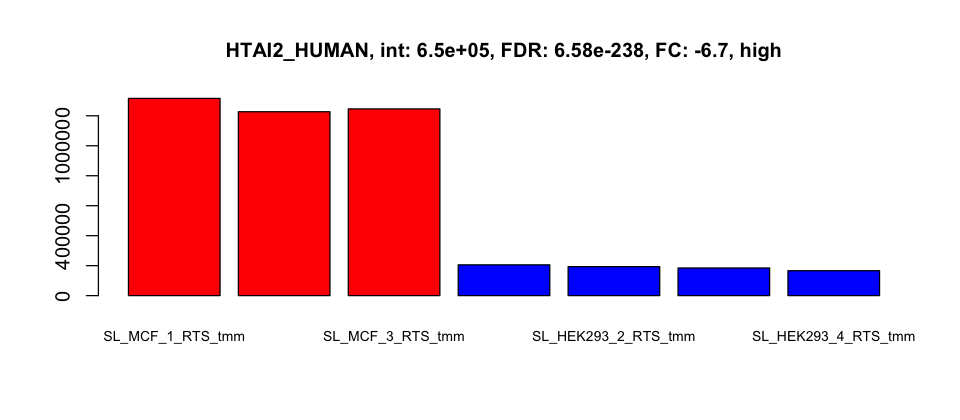

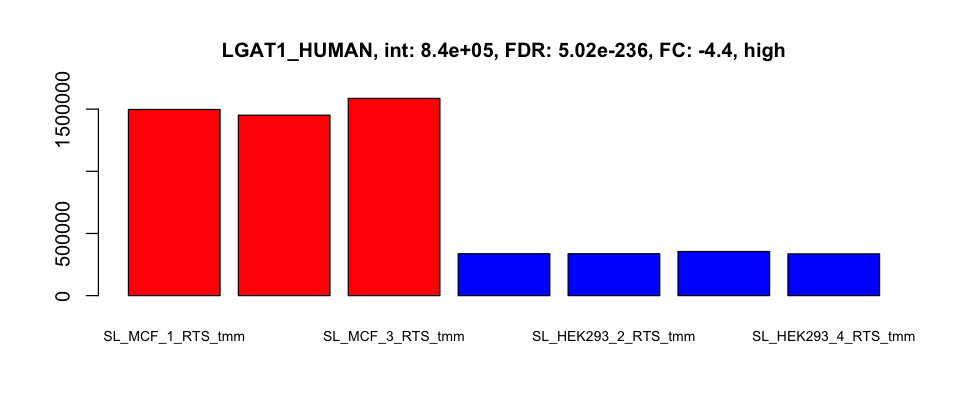

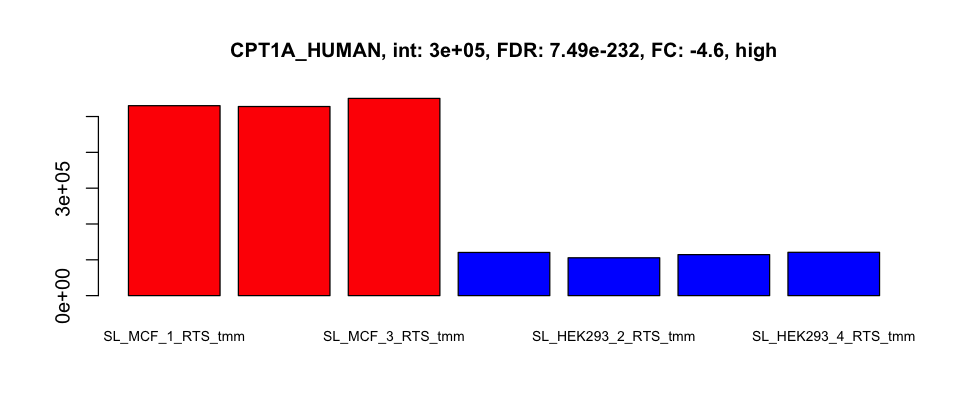

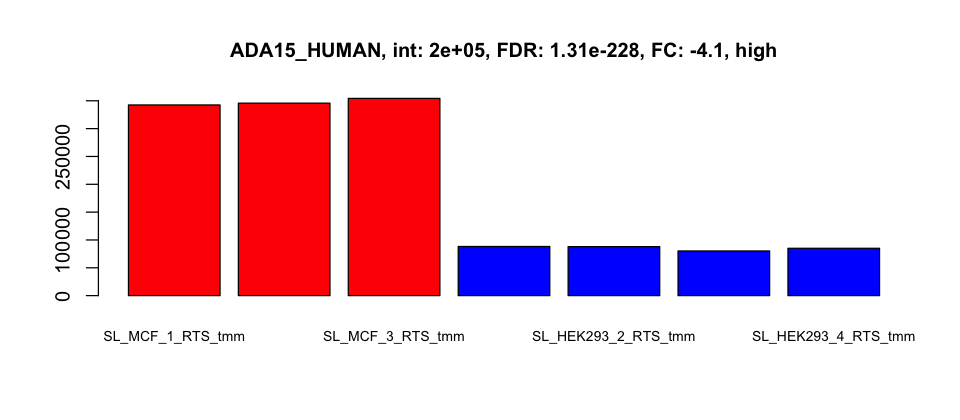

In [30]:
# look at the top candidates
set_plot_dimensions(8, 3.5)
plot_top_tags(results, 3, 4, 10)
set_plot_dimensions(9, 9)

### Individual plots for top candidates are pretty ideal

All three cell lines are consistent. There is excellent reproducibility for biological replicates of each cell line. The three cell lines are different from each other. The questions about how to best rank the proteins that are different between cell lines would apply here. Invoking some fold-change cutoff would be a likely starting point. The linear modeling options in edgeR or limma have functions for adjusting FDR values in combination with a fold-change cutoff. There is also the question of what is the biological question? The three lines could also be compared with ANOVA-like tests. 

---

## Summary

The data seem to be well behaved. We have clear differences in expression levels for a majority of the proteins. The low CVs that can be obtained from cell cultures in combination with the precision of TMT results in very large numbers of statsitically significant differentially expressed proteins. There is nothing about the RTS data that looks odd in any way.

---
## Save the `all_results` frame to TSV file

In [31]:
write.table(all_results, "RTS_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [32]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] janitor_2.0.1   psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3   
 [5] scales_1.1.0    forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5    
 [9] purrr_0.3.3     readr_1.3.1     tidyr_1.0.2     tibble_2.1.3   
[13] ggplot2_3.3.0   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0  